Connected to MetaTrader 5


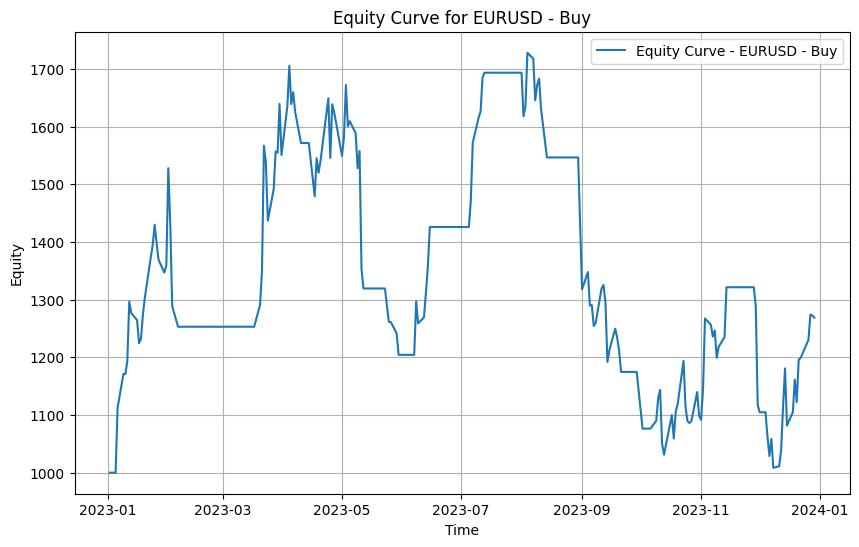

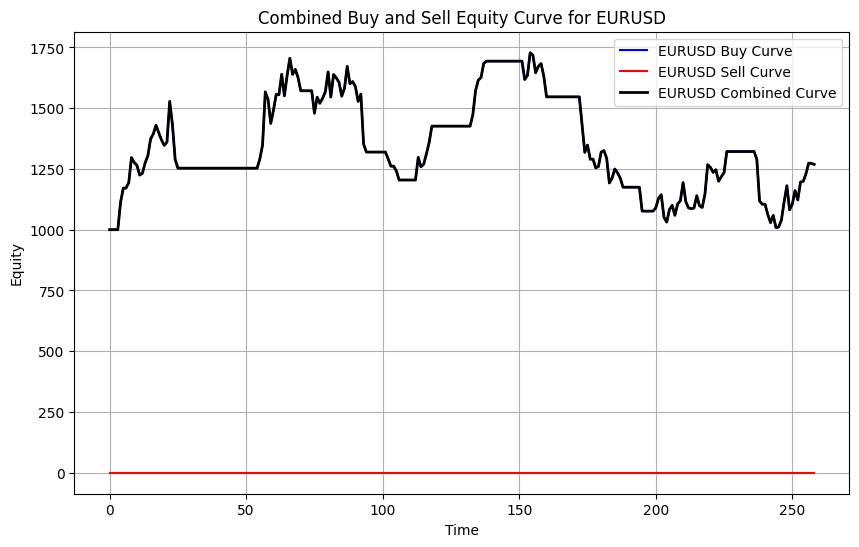


Backtest Summary:

     Pair Signal  Margin  Final Equity  Return (%)  Max Drawdown (%)  \
0  EURUSD    Buy     0.1   1268.789811   26.878981        -41.637283   

   Profit Factor  Sharpe Ratio  Win Rate (%)  Total Trades Avg Trade Duration  \
0       2.037162      0.340281     51.282051            39             8 days   

            Equity Curve Image  
0  EURUSD_Buy_Equity_Curve.png  

Results summary saved to backtest_results_summary.csv


In [15]:
import pandas as pd
import MetaTrader5 as mt5
from backtesting import Backtest, Strategy
import logging
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import os

# Logging configuration
logging.basicConfig(filename='backtest.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# MetaTrader 5 initialization
def init_mt5_connection(login, password, server):
    if not mt5.initialize(login=login, password=password, server=server):
        logging.error(f"initialize() failed, error code = {mt5.last_error()}")
        sys.exit()
    logging.info("Connected to MetaTrader 5")
    print("Connected to MetaTrader 5")

# Fetch historical OHLC data from MetaTrader 5
def fetch_ohlc_data(symbol, timeframe, start_date, end_date):
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        logging.error(f"Failed to fetch data for {symbol}")
        return None
    ohlc_data = pd.DataFrame(data)
    ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')
    ohlc_data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True)
    return ohlc_data[['time', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Load and align prediction data
def load_and_align_data(ohlc_data, prediction_file):
    try:
        predictions = pd.read_csv(prediction_file, parse_dates=['time'])
        if 'prediction' not in predictions.columns:
            logging.error(f"'prediction' column not found in {prediction_file}")
            return None
    except Exception as e:
        logging.error(f"Error loading prediction file: {e}")
        return None
    ohlc_data = ohlc_data.merge(predictions[['time', 'prediction']], on='time', how='left')
    ohlc_data['prediction'] = ohlc_data['prediction'].fillna(0)
    #ohlc_data['prediction'] = ohlc_data['prediction'].shift(1)
    return ohlc_data

# Backtesting strategy for Buy or Sell
class PredictionStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        risk_part, reward_part = self.risk_reward_ratio
        if self.data.prediction[-1] == 1 and self.signal_type == 'Buy':
            sl_price = entry_price - self.mean_candle_size * risk_part
            tp_price = entry_price + self.mean_candle_size * reward_part
            self.buy(sl=sl_price, tp=tp_price)
        elif self.data.prediction[-1] == 1 and self.signal_type == 'Sell':
            sl_price = entry_price + self.mean_candle_size * risk_part
            tp_price = entry_price - self.mean_candle_size * reward_part
            self.sell(sl=sl_price, tp=tp_price)

# Run backtest and store curves
def run_backtest(ohlc_data, strategy_class, risk_reward_ratio, pair_name, signal_type, mean_candle_size, margin, results_summary, combined_data):
    strategy_class.risk_reward_ratio = risk_reward_ratio
    strategy_class.signal_type = signal_type
    strategy_class.mean_candle_size = mean_candle_size
    
    bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=1000, commission=.0003, margin=margin)
    stats = bt.run()
    
    # Store Buy and Sell equity curves separately
    combined_data.setdefault(pair_name, {})
    combined_data[pair_name][signal_type] = stats['_equity_curve']['Equity'].reset_index(drop=True)

    # Plot equity curve
    equity_curve = stats['_equity_curve']['Equity']
    plt.figure(figsize=(10, 6))
    plt.plot(equity_curve, label=f'Equity Curve - {pair_name} - {signal_type}')
    plt.title(f'Equity Curve for {pair_name} - {signal_type}')
    plt.xlabel('Time')
    plt.ylabel('Equity')
    plt.legend()
    plt.grid(True)
    plot_filename = f"{pair_name}_{signal_type}_Equity_Curve.png"
    plt.savefig(plot_filename)
    plt.show()
    
    results_summary.append({
        "Pair": pair_name,
        "Signal": signal_type,
        "Margin": margin,
        "Final Equity": stats['Equity Final [$]'],
        "Return (%)": stats['Return [%]'],
        "Max Drawdown (%)": stats['Max. Drawdown [%]'],
        "Profit Factor": stats['Profit Factor'],
        "Sharpe Ratio": stats['Sharpe Ratio'],
        "Win Rate (%)": stats['Win Rate [%]'],
        "Total Trades": stats['# Trades'],
        "Avg Trade Duration": stats['Avg. Trade Duration'],
        "Equity Curve Image": plot_filename
    })

# Plot separate combined equity curves for each pair
def plot_individual_combined_curves(combined_data):
    for pair_name, curves in combined_data.items():
        buy_curve = curves.get('Buy', pd.Series([0]))
        sell_curve = curves.get('Sell', pd.Series([0]))
        
        max_length = max(len(buy_curve), len(sell_curve))
        buy_curve = buy_curve.reindex(range(max_length), method='ffill').fillna(0)
        sell_curve = sell_curve.reindex(range(max_length), method='ffill').fillna(0)
        combined_curve = buy_curve + sell_curve

        # Plot Combined curve
        plt.figure(figsize=(10, 6))
        plt.plot(buy_curve, label=f'{pair_name} Buy Curve', color='blue')
        plt.plot(sell_curve, label=f'{pair_name} Sell Curve', color='red')
        plt.plot(combined_curve, label=f'{pair_name} Combined Curve', color='black', linewidth=2)
        plt.title(f'Combined Buy and Sell Equity Curve for {pair_name}')
        plt.xlabel('Time')
        plt.ylabel('Equity')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{pair_name}_Combined_Buy_Sell_Equity_Curve.png")
        plt.show()

# Summarize and print backtest results
def summarize_results(results_summary):
    summary_df = pd.DataFrame(results_summary)
    print("\nBacktest Summary:\n")
    print(summary_df)
    
    # Save summary to a CSV file
    summary_filename = "backtest_results_summary.csv"
    summary_df.to_csv(summary_filename, index=False)
    print(f"\nResults summary saved to {summary_filename}")

# Main function
def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',
        'EURUSD': {'symbol': 'EURUSD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.0092, 'buy_prediction_file': 'pred_AUDUSD_Buy.csv', 'sell_prediction_file': 'pred_EURUSD_Sell.csv', 'buy_risk_reward_ratio': (1, 2), 'sell_risk_reward_ratio': (1, 1), 'margin': 0.1},
        #'GBPUSD': {'symbol': 'GBPUSD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.011, 'buy_prediction_file': 'pred_GBPUSD_Buy copy.csv', 'sell_prediction_file': 'pred_GBPUSD_Sell copy.csv', 'buy_risk_reward_ratio': (1, 2), 'sell_risk_reward_ratio': (1, 1), 'margin': 0.1},
        #'AUDUSD': {'symbol': 'AUDUSD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.008, 'buy_prediction_file': 'predAUDUSD_D1_3112buy.csv', 'sell_prediction_file': 'pred_AUDUSD_Sell.csv', 'buy_risk_reward_ratio': (1, 1), 'sell_risk_reward_ratio': (1, 1), 'margin': 0.1},
        #'USDCAD': {'symbol': 'USDCAD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.0085, 'buy_prediction_file': 'pred_USDCAD_Buy.csv', 'sell_prediction_file': 'pred_USDCAD_Sell.csv', 'buy_risk_reward_ratio': (1, 1), 'sell_risk_reward_ratio': (2, 3), 'margin': 0.1}
    }

    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2023, 1, 1, tzinfo=pytz.utc)
    utc_to = datetime(2023, 12, 29, tzinfo=pytz.utc)

    results_summary = []
    combined_data = {}

    for pair_name, pair_config in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue

        ohlc_data = fetch_ohlc_data(pair_config['symbol'], pair_config['timeframe'], utc_from, utc_to)
        if ohlc_data is None:
            continue

        for signal_type in ['Buy', 'Sell']:
            prediction_file = pair_config.get(f'{signal_type.lower()}_prediction_file')
            if prediction_file:
                ohlc_data_with_predictions = load_and_align_data(ohlc_data, prediction_file)
                if ohlc_data_with_predictions is not None:
                    run_backtest(ohlc_data_with_predictions, PredictionStrategy, pair_config[f'{signal_type.lower()}_risk_reward_ratio'], pair_name, signal_type, pair_config['mean_candle_size'], pair_config['margin'], results_summary, combined_data)

    plot_individual_combined_curves(combined_data)
    summarize_results(results_summary)
    mt5.shutdown()

if __name__ == "__main__":
    main()


Connected to MetaTrader 5


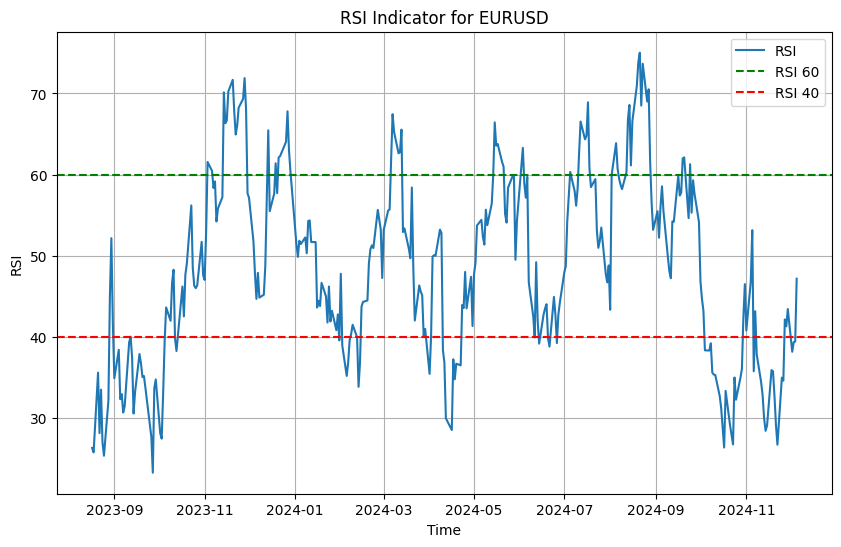

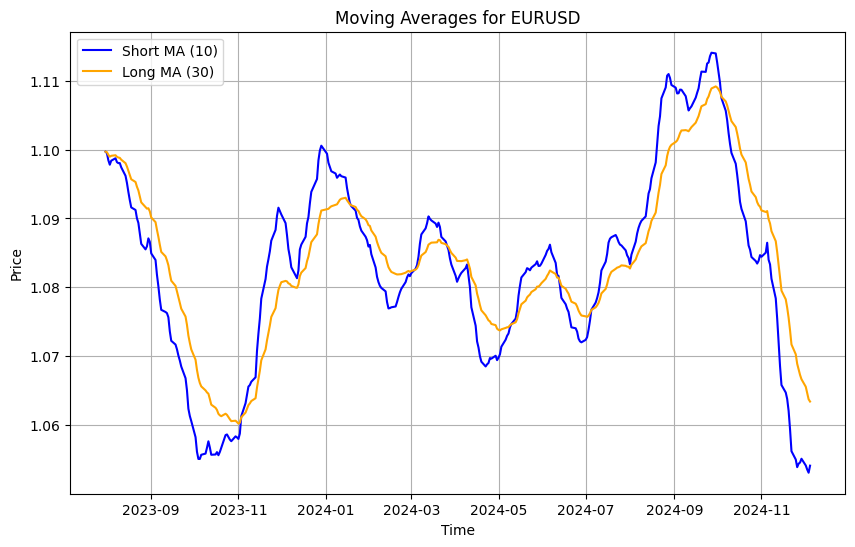

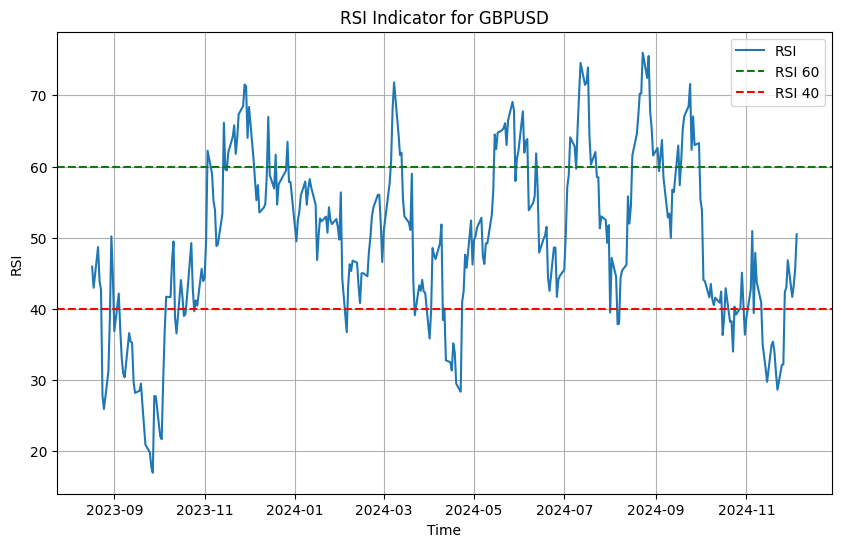

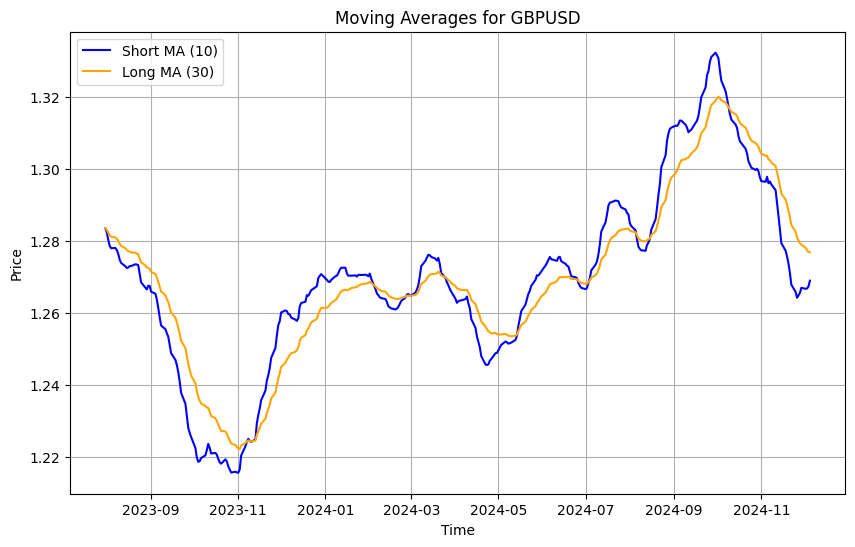

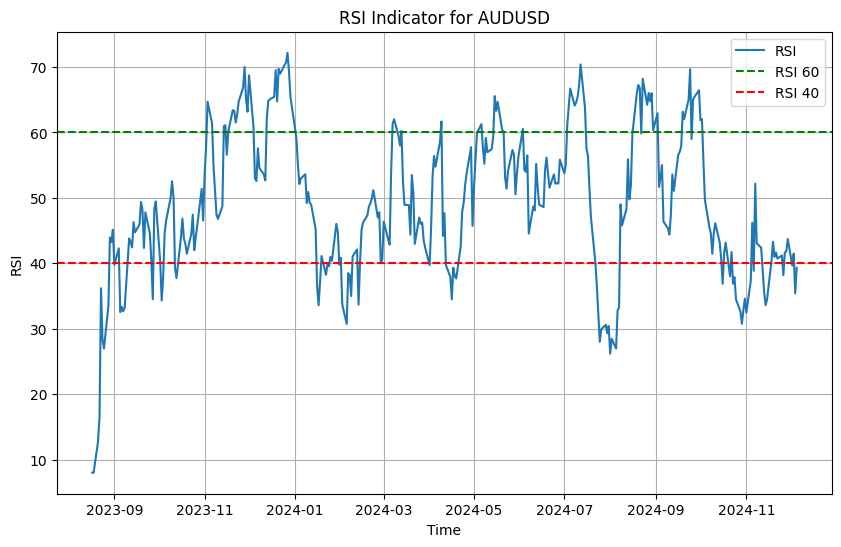

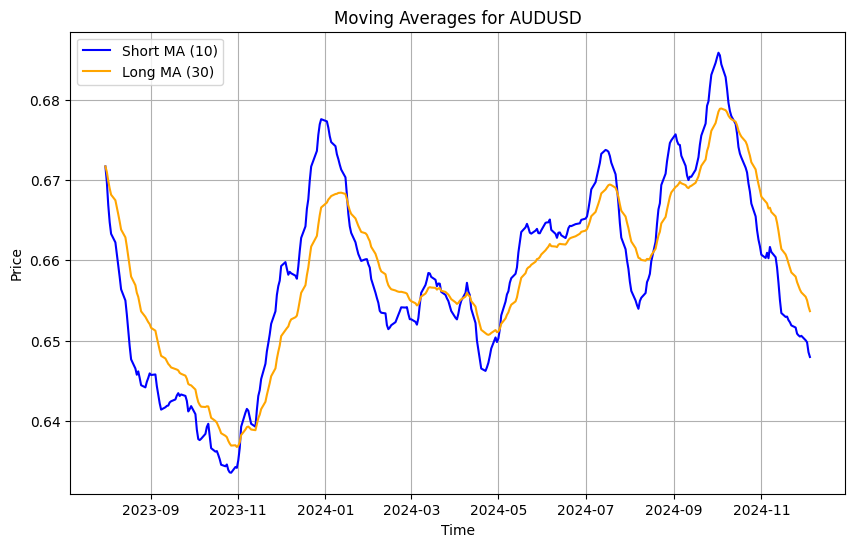

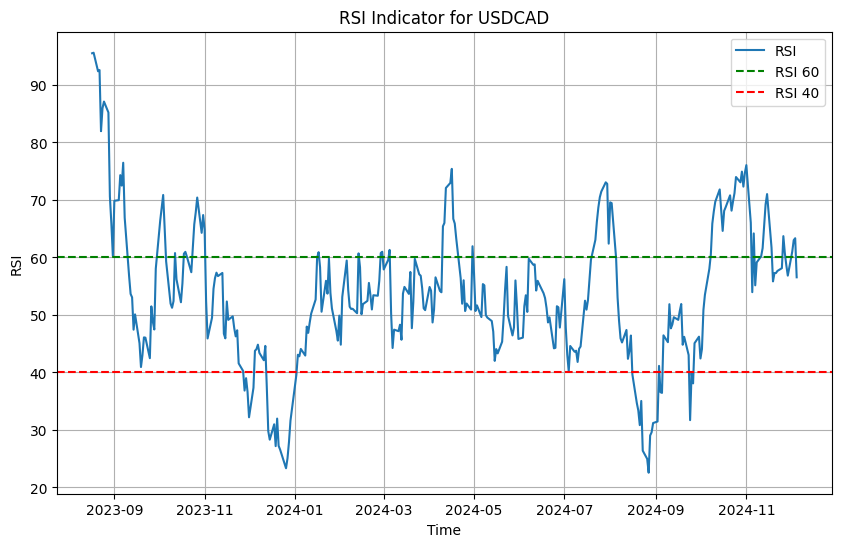

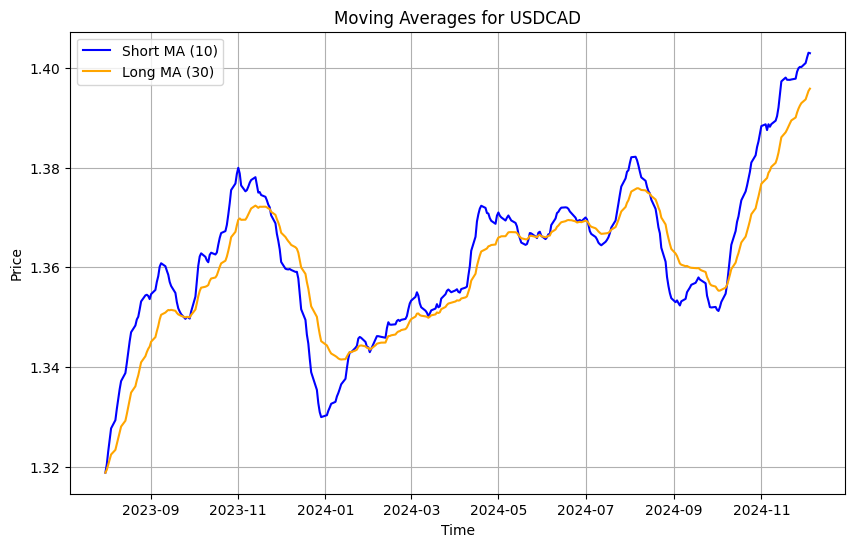

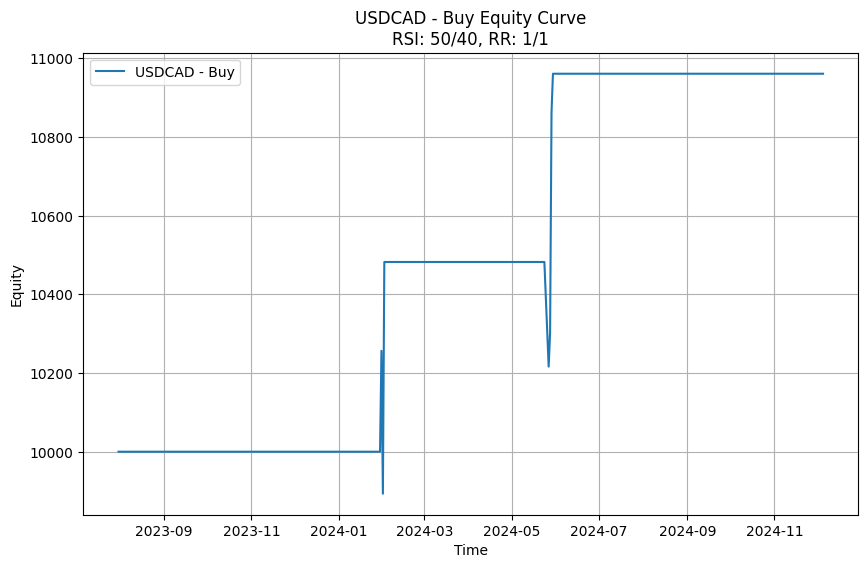

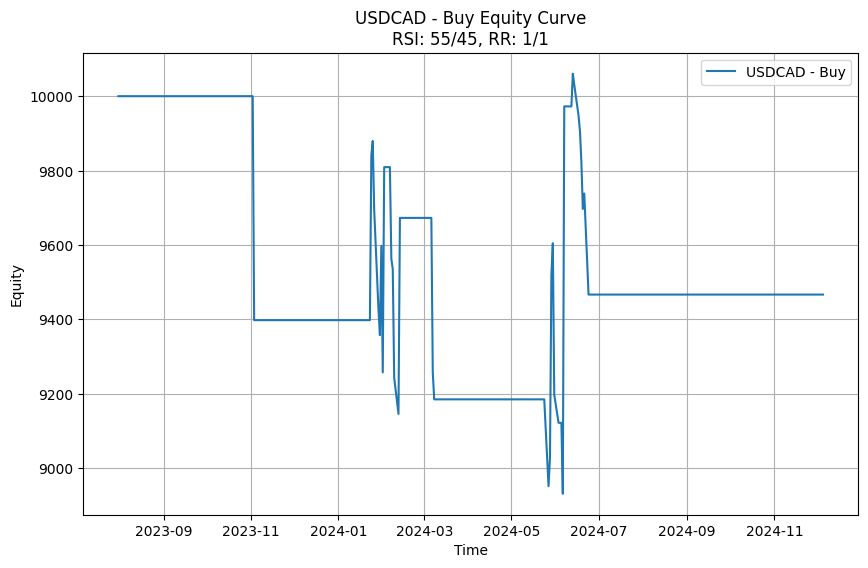

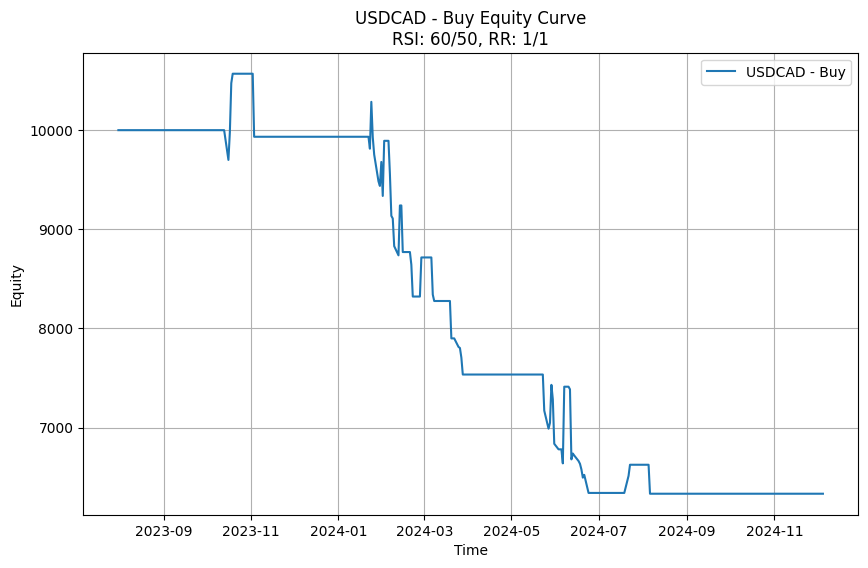

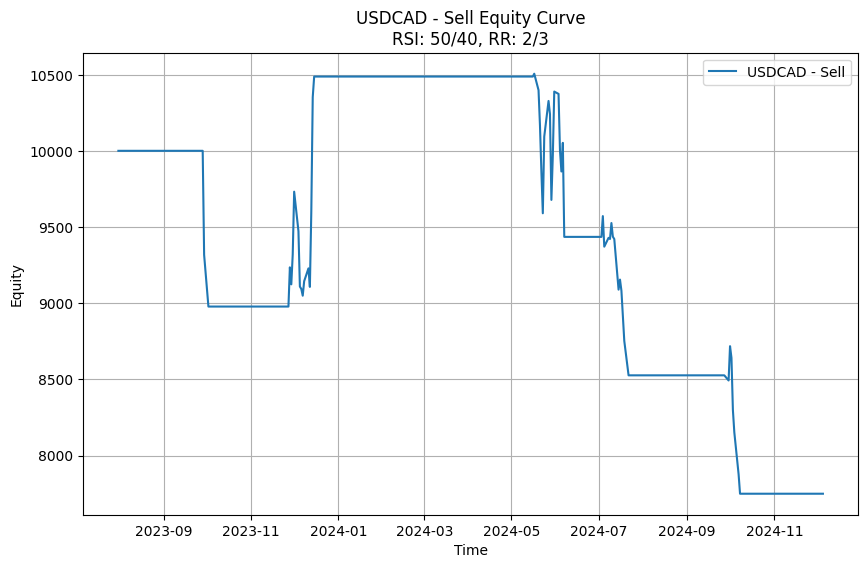

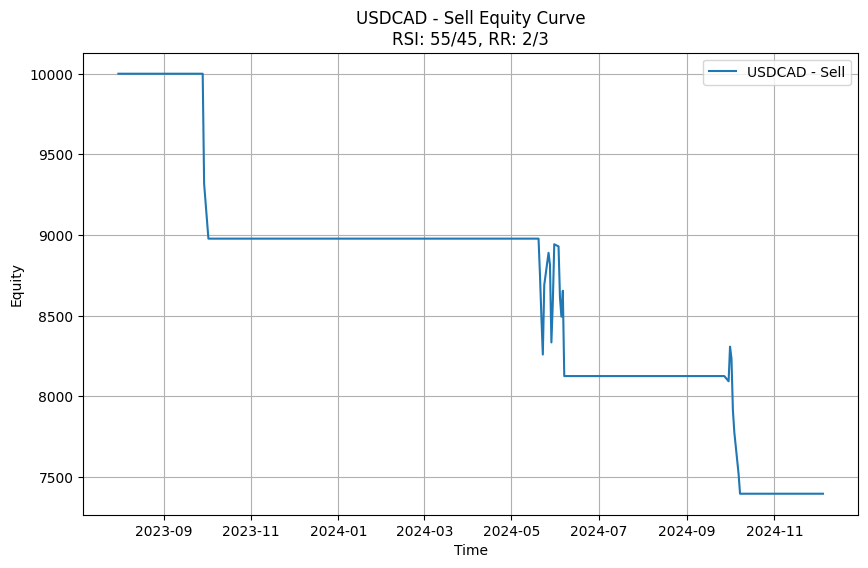

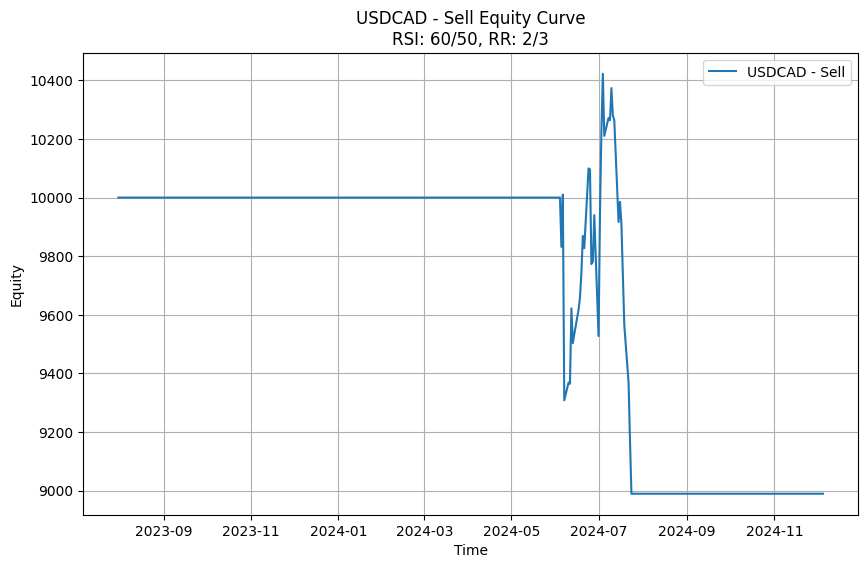

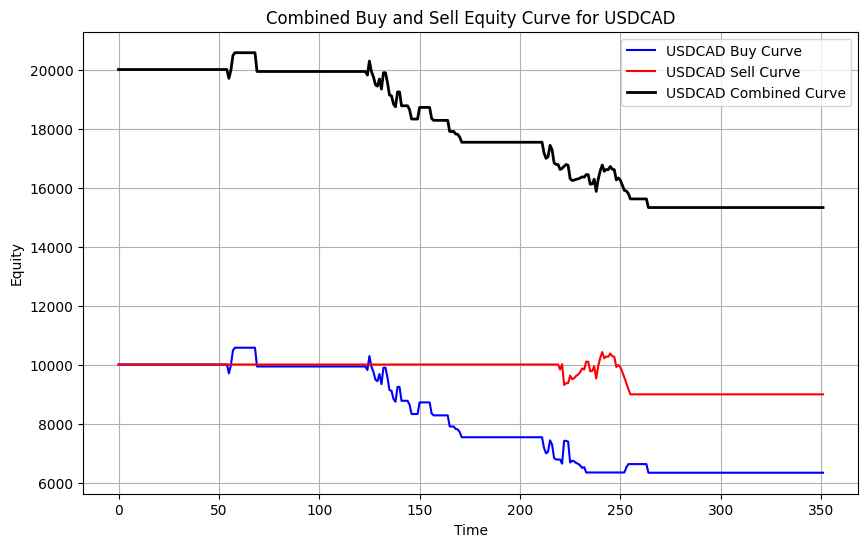


Backtest Summary:

     Pair Signal RSI (Buy/Sell) Risk/Reward Ratio  Final Equity  Return (%)  \
0  USDCAD    Buy          50/40               1/1  10961.266435    9.612664   
1  USDCAD    Buy          55/45               1/1   9466.954118   -5.330459   
2  USDCAD    Buy          60/50               1/1   6331.970306  -36.680297   
3  USDCAD   Sell          50/40               2/3   7749.263429  -22.507366   
4  USDCAD   Sell          55/45               2/3   7396.769340  -26.032307   
5  USDCAD   Sell          60/50               2/3   8989.104986  -10.108950   

   Max Drawdown (%)  Profit Factor  Sharpe Ratio  Win Rate (%)  Total Trades  \
0         -3.543280            NaN      0.780553         100.0             2   
1        -10.681370       0.877997      0.000000          50.0            12   
2        -40.091529       0.533791      0.000000          36.0            25   
3        -26.239642       0.559127      0.000000          25.0             8   
4        -26.032307       

In [10]:
import pandas as pd
import MetaTrader5 as mt5
from backtesting import Backtest, Strategy
import logging
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import os
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange

# Logging configuration
logging.basicConfig(filename='backtest.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# MetaTrader 5 initialization
def init_mt5_connection(login, password, server):
    if not mt5.initialize(login=login, password=password, server=server):
        logging.error(f"initialize() failed, error code = {mt5.last_error()}")
        sys.exit()
    logging.info("Connected to MetaTrader 5")
    print("Connected to MetaTrader 5")

# Fetch historical OHLC data from MetaTrader 5
def fetch_ohlc_data(symbol, timeframe, start_date, end_date):
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        logging.error(f"Failed to fetch data for {symbol}")
        return None
    ohlc_data = pd.DataFrame(data)
    ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')
    ohlc_data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True)
    return ohlc_data[['time', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Add technical indicators to the OHLC data
def add_technical_indicators(ohlc_data):
    # RSI
    ohlc_data['rsi'] = RSIIndicator(ohlc_data['Close'], window=14).rsi()  # Standard RSI window of 14
    
    # Moving Averages
    # Replace SMA with EMA  
    ohlc_data['short_ma'] = ohlc_data['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
    ohlc_data['long_ma'] = ohlc_data['Close'].ewm(span=30, adjust=False).mean()  # Long-term EMA

    #ohlc_data['short_ma'] = ohlc_data['Close'].rolling(window=10).mean()  # Increased MA period to 10 for smoother signals
    #ohlc_data['long_ma'] = ohlc_data['Close'].rolling(window=30).mean()  # Increased MA period to 30
    
    # MACD Calculation
    short_ema = ohlc_data['Close'].ewm(span=12, adjust=False).mean()  # Standard MACD short period
    long_ema = ohlc_data['Close'].ewm(span=26, adjust=False).mean()  # Standard MACD long period
    ohlc_data['macd'] = short_ema - long_ema
    ohlc_data['macd_signal'] = ohlc_data['macd'].ewm(span=9, adjust=False).mean()  # Standard MACD signal line
    
    # Average True Range (ATR)
    atr_indicator = AverageTrueRange(ohlc_data['High'], ohlc_data['Low'], ohlc_data['Close'], window=14)
    ohlc_data['atr'] = atr_indicator.average_true_range()
    
    return ohlc_data

# Load and align prediction data
def load_and_align_data(ohlc_data, prediction_file):
    try:
        predictions = pd.read_csv(prediction_file, parse_dates=['time'])
        if 'prediction' not in predictions.columns:
            logging.error(f"'prediction' column not found in {prediction_file}")
            return None
    except Exception as e:
        logging.error(f"Error loading prediction file: {e}")
        return None
    ohlc_data = ohlc_data.merge(predictions[['time', 'prediction']], on='time', how='left')
    ohlc_data['prediction'] = ohlc_data['prediction'].fillna(0)
    return ohlc_data

# Backtesting strategy for Buy or Sell
class PredictionStrategy(Strategy):
    pair_name = None
    rsi_threshold_buy = 60
    rsi_threshold_sell = 40
    atr_multiplier_sl = 1.5
    atr_multiplier_tp = 2.0

    def init(self):
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        atr_value = self.data.atr[-1]
        volume_threshold = 1000

        # Buy conditions
        buy_conditions_met = (
            (self.data.rsi[-1] < self.rsi_threshold_buy) &
            (self.data.short_ma[-1] > self.data.long_ma[-1]) &
            (self.data.macd[-1] > self.data.macd_signal[-1]) &
            (self.data.Volume[-1] > volume_threshold)
        )

        # Sell conditions
        sell_conditions_met = (
            (self.data.rsi[-1] > self.rsi_threshold_sell) &
            (self.data.short_ma[-1] < self.data.long_ma[-1]) &
            (self.data.macd[-1] < self.data.macd_signal[-1]) &
            (self.data.Volume[-1] > volume_threshold)
        )

        # Execute trades
        if self.data.prediction[-1] == 1 and self.signal_type == 'Buy' and buy_conditions_met:
            sl_price = entry_price - (atr_value * self.atr_multiplier_sl)
            tp_price = entry_price + (atr_value * self.atr_multiplier_tp)
            self.buy(sl=sl_price, tp=tp_price)
        elif self.data.prediction[-1] == 1 and self.signal_type == 'Sell' and sell_conditions_met:
            sl_price = entry_price + (atr_value * self.atr_multiplier_sl)
            tp_price = entry_price - (atr_value * self.atr_multiplier_tp)
            self.sell(sl=sl_price, tp=tp_price)


# Run backtest and store curves
""" def run_backtest(ohlc_data, strategy_class, risk_reward_ratio, pair_name, signal_type, mean_candle_size, margin, results_summary, combined_data):
    # Set pair-specific parameters
    if pair_name == 'EURUSD':
        strategy_class.rsi_threshold_buy = 65
        strategy_class.rsi_threshold_sell = 40
        strategy_class.atr_multiplier_sl = 1.5
        strategy_class.atr_multiplier_tp = 2.0
    elif pair_name == 'GBPUSD':
        strategy_class.rsi_threshold_buy = 60
        strategy_class.rsi_threshold_sell = 45
        strategy_class.atr_multiplier_sl = 1.2
        strategy_class.atr_multiplier_tp = 1.5
    elif pair_name == 'AUDUSD':
        strategy_class.rsi_threshold_buy = 60
        strategy_class.rsi_threshold_sell = 50
        strategy_class.atr_multiplier_sl = 1.3
        strategy_class.atr_multiplier_tp = 2.0
    elif pair_name == 'USDCAD':
        strategy_class.rsi_threshold_buy = 55
        strategy_class.rsi_threshold_sell = 45
        strategy_class.atr_multiplier_sl = 1.1
        strategy_class.atr_multiplier_tp = 1.5

    strategy_class.signal_type = signal_type

    bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=10000, commission=.0003, margin=margin)
    stats = bt.run()

    # Store Buy and Sell equity curves separately
    combined_data.setdefault(pair_name, {})
    combined_data[pair_name][signal_type] = stats['_equity_curve']['Equity'].reset_index(drop=True)

    # Plot equity curve
    equity_curve = stats['_equity_curve']['Equity']
    plt.figure(figsize=(10, 6))
    plt.plot(equity_curve, label=f'Equity Curve - {pair_name} - {signal_type}')
    plt.title(f'Equity Curve for {pair_name} - {signal_type}')
    plt.xlabel('Time')
    plt.ylabel('Equity')
    plt.legend()
    plt.grid(True)
    plot_filename = f"{pair_name}_{signal_type}_Equity_Curve.png"
    plt.savefig(plot_filename)
    plt.show()

    results_summary.append({
        "Pair": pair_name,
        "Signal": signal_type,
        "Margin": margin,
        "Final Equity": stats['Equity Final [$]'],
        "Return (%)": stats['Return [%]'],
        "Max Drawdown (%)": stats['Max. Drawdown [%]'],
        "Profit Factor": stats['Profit Factor'],
        "Sharpe Ratio": stats['Sharpe Ratio'],
        "Win Rate (%)": stats['Win Rate [%]'],
        "Total Trades": stats['# Trades'],
        "Avg Trade Duration": stats['Avg. Trade Duration'],
        "Equity Curve Image": plot_filename
    })
 """
def run_backtest_with_variations(ohlc_data, strategy_class, pair_name, signal_type, margin, results_summary, combined_data, risk_reward_ratio):
    # Define RSI threshold variations for each pair
    rsi_thresholds = {
        'EURUSD': [(60, 40), (65, 40), (70, 45)],
        'GBPUSD': [(60, 45), (65, 50), (70, 55)],
        'AUDUSD': [(55, 45), (60, 50), (65, 55)],
        'USDCAD': [(50, 40), (55, 45), (60, 50)],
    }

    # Extract fixed risk-reward ratios
    risk_part, reward_part = risk_reward_ratio

    # Iterate through RSI threshold variations
    for rsi_buy, rsi_sell in rsi_thresholds.get(pair_name, [(60, 40)]):
        # Set strategy-specific parameters
        strategy_class.rsi_threshold_buy = rsi_buy
        strategy_class.rsi_threshold_sell = rsi_sell
        strategy_class.atr_multiplier_sl = risk_part  # Using risk_part for SL multiplier
        strategy_class.atr_multiplier_tp = reward_part  # Using reward_part for TP multiplier
        strategy_class.signal_type = signal_type

        # Run the backtest
        bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=10000, commission=0.0003, margin=margin)
        stats = bt.run()

        # Store Buy and Sell equity curves separately
        combined_data.setdefault(pair_name, {})
        combined_data[pair_name][signal_type] = stats['_equity_curve']['Equity'].reset_index(drop=True)

        # Plot equity curve
        equity_curve = stats['_equity_curve']['Equity']
        plt.figure(figsize=(10, 6))
        plt.plot(equity_curve, label=f'{pair_name} - {signal_type}')
        plt.title(f'{pair_name} - {signal_type} Equity Curve\nRSI: {rsi_buy}/{rsi_sell}, RR: {risk_part}/{reward_part}')
        plt.xlabel('Time')
        plt.ylabel('Equity')
        plt.legend()
        plt.grid(True)
        plot_filename = f"{pair_name}_{signal_type}_Equity_Curve_RSI_{rsi_buy}_{rsi_sell}_RR_{risk_part}_{reward_part}.png"
        plt.savefig(plot_filename)
        plt.show()

        # Append results
        results_summary.append({
            "Pair": pair_name,
            "Signal": signal_type,
            "RSI (Buy/Sell)": f"{rsi_buy}/{rsi_sell}",
            "Risk/Reward Ratio": f"{risk_part}/{reward_part}",
            "Final Equity": stats['Equity Final [$]'],
            "Return (%)": stats['Return [%]'],
            "Max Drawdown (%)": stats['Max. Drawdown [%]'],
            "Profit Factor": stats['Profit Factor'],
            "Sharpe Ratio": stats['Sharpe Ratio'],
            "Win Rate (%)": stats['Win Rate [%]'],
            "Total Trades": stats['# Trades'],
            "Avg Trade Duration": stats['Avg. Trade Duration'],
            "Equity Curve Image": plot_filename,
        })


# Plot separate combined equity curves for each pair
def plot_individual_combined_curves(combined_data):
    for pair_name, curves in combined_data.items():
        buy_curve = curves.get('Buy', pd.Series([0]))
        sell_curve = curves.get('Sell', pd.Series([0]))
        
        max_length = max(len(buy_curve), len(sell_curve))
        buy_curve = buy_curve.reindex(range(max_length), method='ffill').fillna(0)
        sell_curve = sell_curve.reindex(range(max_length), method='ffill').fillna(0)
        combined_curve = buy_curve + sell_curve

        # Plot Combined curve
        plt.figure(figsize=(10, 6))
        plt.plot(buy_curve, label=f'{pair_name} Buy Curve', color='blue')
        plt.plot(sell_curve, label=f'{pair_name} Sell Curve', color='red')
        plt.plot(combined_curve, label=f'{pair_name} Combined Curve', color='black', linewidth=2)
        plt.title(f'Combined Buy and Sell Equity Curve for {pair_name}')
        plt.xlabel('Time')
        plt.ylabel('Equity')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{pair_name}_Combined_Buy_Sell_Equity_Curve.png")
        plt.show()

# Summarize and print backtest results
def summarize_results(results_summary):
    summary_df = pd.DataFrame(results_summary)
    print("\nBacktest Summary:\n")
    print(summary_df)
    
    # Save summary to a CSV file
    summary_filename = "backtest_results_summary.csv"
    summary_df.to_csv(summary_filename, index=False)
    print(f"\nResults summary saved to {summary_filename}")

# Main function
def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',
        'EURUSD': {'symbol': 'EURUSD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.0092, 'buy_prediction_file': 'pred_EURUSD_Buy.csv', 'sell_prediction_file': 'pred_EURUSD_Sell.csv', 'buy_risk_reward_ratio': (1, 2), 'sell_risk_reward_ratio': (1, 1), 'margin': 0.1},
        'GBPUSD': {'symbol': 'GBPUSD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.011, 'buy_prediction_file': 'pred_GBPUSD_Buy copy.csv', 'sell_prediction_file': 'pred_GBPUSD_Sell copy.csv', 'buy_risk_reward_ratio': (1, 3), 'sell_risk_reward_ratio': (1, 2), 'margin': 0.1},
        'AUDUSD': {'symbol': 'AUDUSD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.008, 'buy_prediction_file': 'pred_AUDUSD_Buy.csv', 'sell_prediction_file': 'pred_AUDUSD_Sell.csv', 'buy_risk_reward_ratio': (1, 2), 'sell_risk_reward_ratio': (1, 1), 'margin': 0.1},
        'USDCAD': {'symbol': 'USDCAD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.0085, 'buy_prediction_file': 'pred_USDCAD_Buy.csv', 'sell_prediction_file': 'pred_USDCAD_Sell.csv', 'buy_risk_reward_ratio': (1, 1), 'sell_risk_reward_ratio': (2, 3), 'margin': 0.1}
    }

    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2023, 7, 31, tzinfo=pytz.utc)
    utc_to = datetime(2024, 12, 5, tzinfo=pytz.utc)

    results_summary = []
    combined_data = {}

    for pair_name, pair_config in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue

        ohlc_data = fetch_ohlc_data(pair_config['symbol'], pair_config['timeframe'], utc_from, utc_to)
        if ohlc_data is None:
            continue

        # Add technical indicators to the OHLC data
        ohlc_data = add_technical_indicators(ohlc_data)

        # Plot RSI and Moving Averages for analysis
        plt.figure(figsize=(10, 6))
        plt.plot(ohlc_data['time'], ohlc_data['rsi'], label='RSI')
        plt.axhline(y=60, color='green', linestyle='--', label='RSI 60')
        plt.axhline(y=40, color='red', linestyle='--', label='RSI 40')
        plt.title(f'RSI Indicator for {pair_name}')
        plt.xlabel('Time')
        plt.ylabel('RSI')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{pair_name}_RSI.png")
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(ohlc_data['time'], ohlc_data['short_ma'], label='Short MA (10)', color='blue')
        plt.plot(ohlc_data['time'], ohlc_data['long_ma'], label='Long MA (30)', color='orange')
        plt.title(f'Moving Averages for {pair_name}')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{pair_name}_Moving_Averages.png")
        plt.show()

    for signal_type in ['Buy', 'Sell']:
        prediction_file = pair_config.get(f'{signal_type.lower()}_prediction_file')
        if prediction_file:
            ohlc_data_with_predictions = load_and_align_data(ohlc_data, prediction_file)
            if   ohlc_data_with_predictions is not None:
                risk_reward_ratio = pair_config[f'{signal_type.lower()}_risk_reward_ratio']
                run_backtest_with_variations(
                ohlc_data_with_predictions,
                PredictionStrategy,
                pair_name,
                signal_type,
                pair_config['margin'],
                results_summary,
                combined_data,
                risk_reward_ratio
            )


    plot_individual_combined_curves(combined_data)
    summarize_results(results_summary)
    mt5.shutdown()

if __name__ == "__main__":
    main()



2024-11-29 15:45:47,294 - Connected to MetaTrader 5


Connected to MetaTrader 5


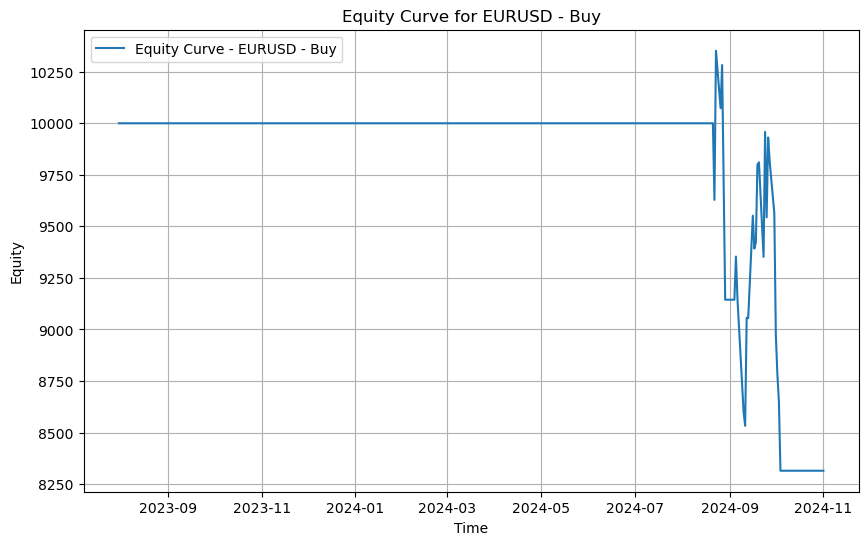

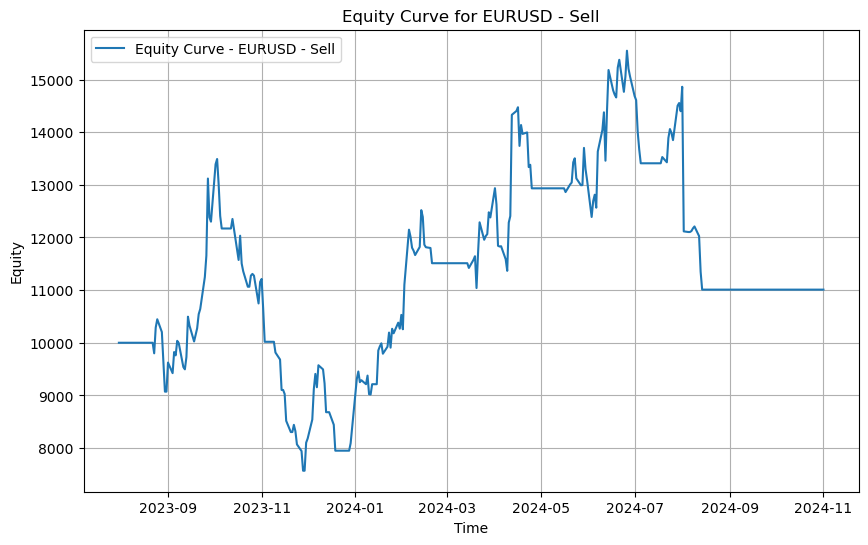

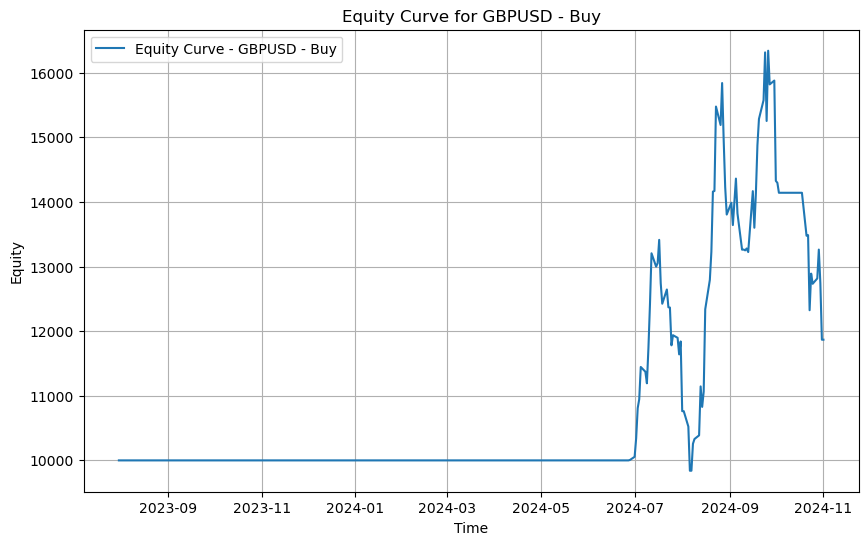

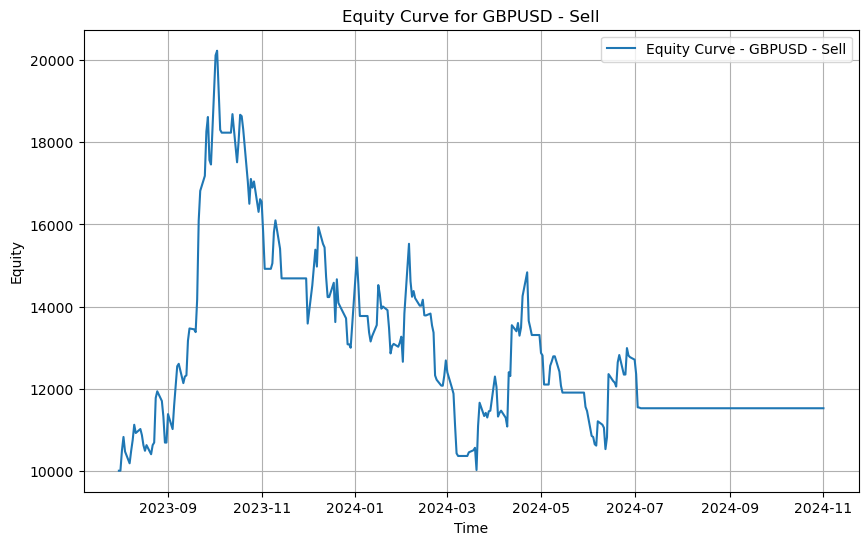

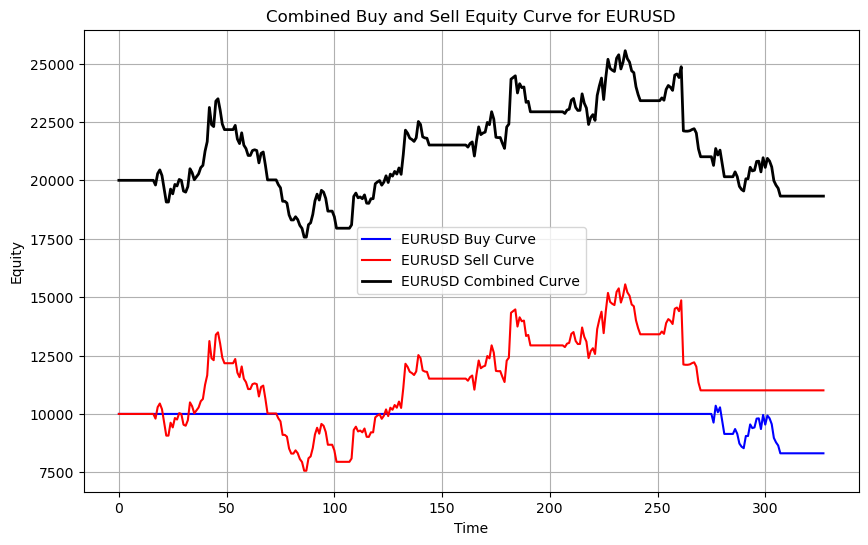

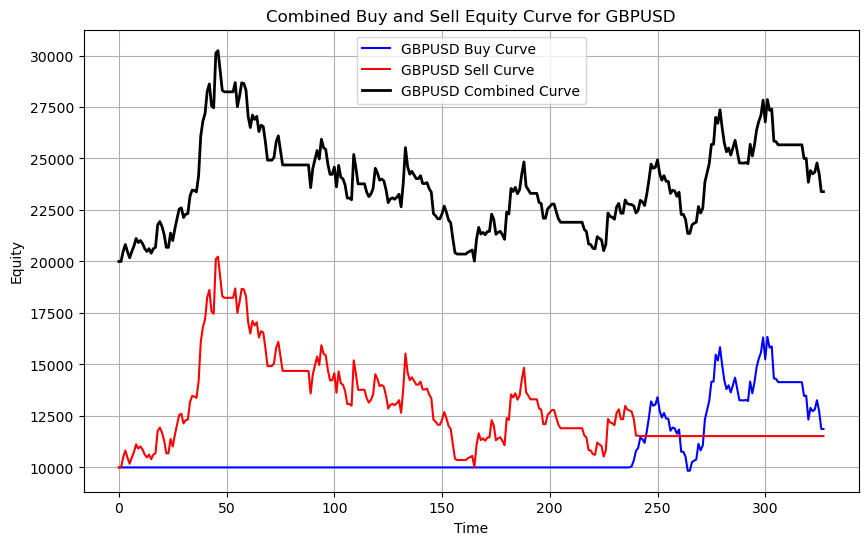

In [15]:
import pandas as pd
import MetaTrader5 as mt5
from backtesting import Backtest, Strategy
import logging
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import os

# Logging configuration
logging.basicConfig(filename='backtest.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# MetaTrader 5 initialization
def init_mt5_connection(login, password, server):
    if not mt5.initialize(login=login, password=password, server=server):
        logging.error(f"initialize() failed, error code = {mt5.last_error()}")
        sys.exit()
    logging.info("Connected to MetaTrader 5")
    print("Connected to MetaTrader 5")

# Fetch historical OHLC data from MetaTrader 5
def fetch_ohlc_data(symbol, timeframe, start_date, end_date):
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        logging.error(f"Failed to fetch data for {symbol}")
        return None
    ohlc_data = pd.DataFrame(data)
    ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')
    ohlc_data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True)
    return ohlc_data[['time', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Add EMA calculation to the OHLC data
def add_ema(data, short_period=150, long_period=200):
    data['short_ema'] = data['Close'].ewm(span=short_period, adjust=False).mean()
    data['long_ema'] = data['Close'].ewm(span=long_period, adjust=False).mean()
    return data

# Load and align prediction data
def load_and_align_data(ohlc_data, prediction_file):
    try:
        predictions = pd.read_csv(prediction_file, parse_dates=['time'])
        if 'prediction' not in predictions.columns:
            logging.error(f"'prediction' column not found in {prediction_file}")
            return None
    except Exception as e:
        logging.error(f"Error loading prediction file: {e}")
        return None
    ohlc_data = ohlc_data.merge(predictions[['time', 'prediction']], on='time', how='left')
    ohlc_data['prediction'] = ohlc_data['prediction'].fillna(0)
    ohlc_data['prediction'] = ohlc_data['prediction'].shift(-1)
    return ohlc_data

# Backtesting strategy for Buy or Sell with EMA filtering
class EMAFilteredPredictionStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        risk_part, reward_part = self.risk_reward_ratio

        # Check if trend aligns with signal using EMA
        is_bullish_trend = self.data.short_ema[-1] > self.data.long_ema[-1]
        is_bearish_trend = self.data.short_ema[-1] < self.data.long_ema[-1]

        # Buy signal if in bullish trend
        if self.data.prediction[-1] == 1 and self.signal_type == 'Buy' and is_bullish_trend:
            sl_price = entry_price - self.mean_candle_size * risk_part
            tp_price = entry_price + self.mean_candle_size * reward_part
            self.buy(sl=sl_price, tp=tp_price)

        # Sell signal if in bearish trend
        elif self.data.prediction[-1] == 1 and self.signal_type == 'Sell' and is_bearish_trend:
            sl_price = entry_price + self.mean_candle_size * risk_part
            tp_price = entry_price - self.mean_candle_size * reward_part
            self.sell(sl=sl_price, tp=tp_price)

# Run backtest and store curves
def run_backtest(ohlc_data, strategy_class, risk_reward_ratio, pair_name, signal_type, mean_candle_size, margin, results_summary, combined_data):
    strategy_class.risk_reward_ratio = risk_reward_ratio
    strategy_class.signal_type = signal_type
    strategy_class.mean_candle_size = mean_candle_size
    
    bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=10000, commission=.0003, margin=margin)
    stats = bt.run()
    
    # Store Buy and Sell equity curves separately
    combined_data.setdefault(pair_name, {})
    combined_data[pair_name][signal_type] = stats['_equity_curve']['Equity'].reset_index(drop=True)

    # Plot equity curve
    equity_curve = stats['_equity_curve']['Equity']
    plt.figure(figsize=(10, 6))
    plt.plot(equity_curve, label=f'Equity Curve - {pair_name} - {signal_type}')
    plt.title(f'Equity Curve for {pair_name} - {signal_type}')
    plt.xlabel('Time')
    plt.ylabel('Equity')
    plt.legend()
    plt.grid(True)
    plot_filename = f"{pair_name}_{signal_type}_Equity_Curve.png"
    plt.savefig(plot_filename)
    plt.show()
    
    results_summary.append({
        "Pair": pair_name,
        "Signal": signal_type,
        "Margin": margin,
        "Final Equity": stats['Equity Final [$]'],
        "Return (%)": stats['Return [%]'],
        "Max Drawdown (%)": stats['Max. Drawdown [%]'],
        "Profit Factor": stats['Profit Factor'],
        "Sharpe Ratio": stats['Sharpe Ratio'],
        "Equity Curve Image": plot_filename
    })

# Plot combined equity curves for each pair
def plot_individual_combined_curves(combined_data):
    for pair_name, curves in combined_data.items():
        buy_curve = curves.get('Buy', pd.Series([0]))
        sell_curve = curves.get('Sell', pd.Series([0]))

        # Ensure both curves are of the same length
        max_length = max(len(buy_curve), len(sell_curve))
        buy_curve = buy_curve.reindex(range(max_length), method='ffill').fillna(0)
        sell_curve = sell_curve.reindex(range(max_length), method='ffill').fillna(0)

        # Calculate the combined equity curve
        combined_curve = buy_curve + sell_curve

        # Plot Combined curve only
        plt.figure(figsize=(10, 6))
        plt.plot(buy_curve, label=f'{pair_name} Buy Curve', color='blue')
        plt.plot(sell_curve, label=f'{pair_name} Sell Curve', color='red')
        plt.plot(combined_curve, label=f'{pair_name} Combined Curve', color='black', linewidth=2)
        plt.title(f'Combined Buy and Sell Equity Curve for {pair_name}')
        plt.xlabel('Time')
        plt.ylabel('Equity')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{pair_name}_Combined_Buy_Sell_Equity_Curve.png")
        plt.show()

# Main function
def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',
        'EURUSD': {'symbol': 'EURUSD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.0092, 'buy_prediction_file': 'pred_EURUSD_Buy.csv', 'sell_prediction_file': 'pred_EURUSD_Sell.csv', 'buy_risk_reward_ratio': (1, 2), 'sell_risk_reward_ratio': (1, 1), 'margin': 0.1},
        'GBPUSD': {'symbol': 'GBPUSD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.011, 'buy_prediction_file': 'pred_GBPUSD_Buy.csv', 'sell_prediction_file': 'pred_GBPUSD_Sell.csv', 'buy_risk_reward_ratio': (1, 2), 'sell_risk_reward_ratio': (1, 1), 'margin': 0.1},
        #'AUDUSD': {'symbol': 'AUDUSD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.008, 'buy_prediction_file': 'pred_AUDUSD_Buy.csv', 'sell_prediction_file': 'pred_AUDUSD_Sell.csv', 'buy_risk_reward_ratio': (1, 2), 'sell_risk_reward_ratio': (1, 1), 'margin': 0.1},
        #'USDCAD': {'symbol': 'USDCAD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.0085, 'buy_prediction_file': 'pred_USDCAD_Buy.csv', 'sell_prediction_file': 'pred_USDCAD_Sell.csv', 'buy_risk_reward_ratio': (1, 1), 'sell_risk_reward_ratio': (2, 3), 'margin': 0.1}
    }
    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2023, 7, 31, tzinfo=pytz.utc)
    utc_to = datetime(2024, 11, 1, tzinfo=pytz.utc)

    results_summary = []
    combined_data = {}

    for pair_name, pair_config in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue

        ohlc_data = fetch_ohlc_data(pair_config['symbol'], pair_config['timeframe'], utc_from, utc_to)
        if ohlc_data is None:
            continue

        # Add EMA to OHLC data
        ohlc_data = add_ema(ohlc_data)

        for signal_type in ['Buy', 'Sell']:
            prediction_file = pair_config.get(f'{signal_type.lower()}_prediction_file')
            if prediction_file:
                ohlc_data_with_predictions = load_and_align_data(ohlc_data, prediction_file)
                if ohlc_data_with_predictions is not None:
                    run_backtest(ohlc_data_with_predictions, EMAFilteredPredictionStrategy, pair_config[f'{signal_type.lower()}_risk_reward_ratio'],
                                 pair_name, signal_type, pair_config['mean_candle_size'], pair_config['margin'], results_summary, combined_data)

    plot_individual_combined_curves(combined_data)
    mt5.shutdown()

if __name__ == "__main__":
    main()


Connected to MetaTrader 5


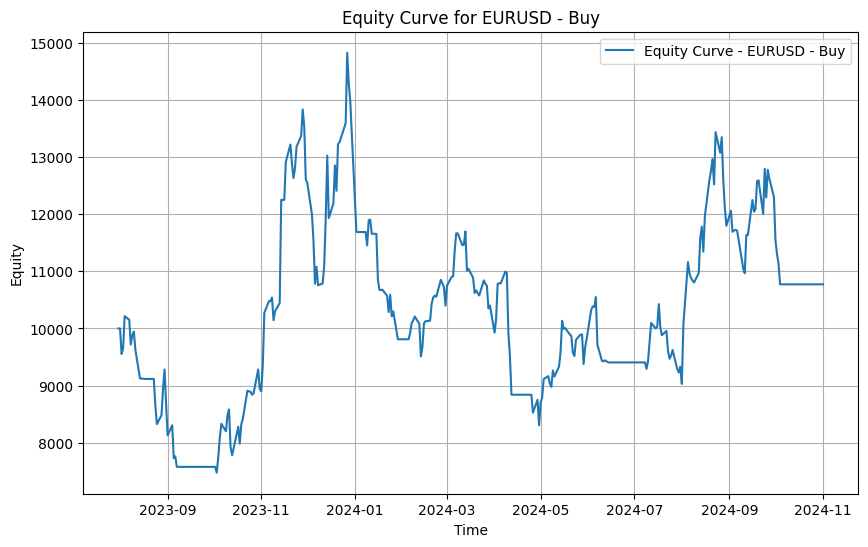

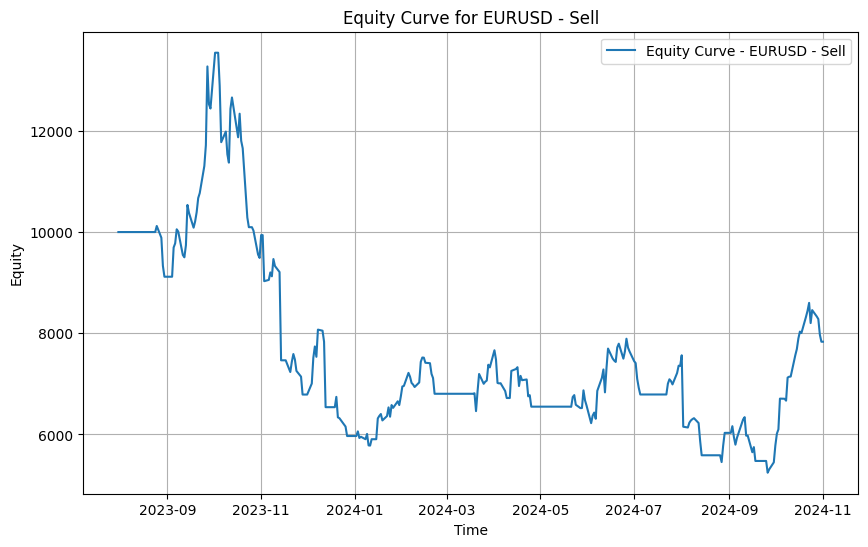

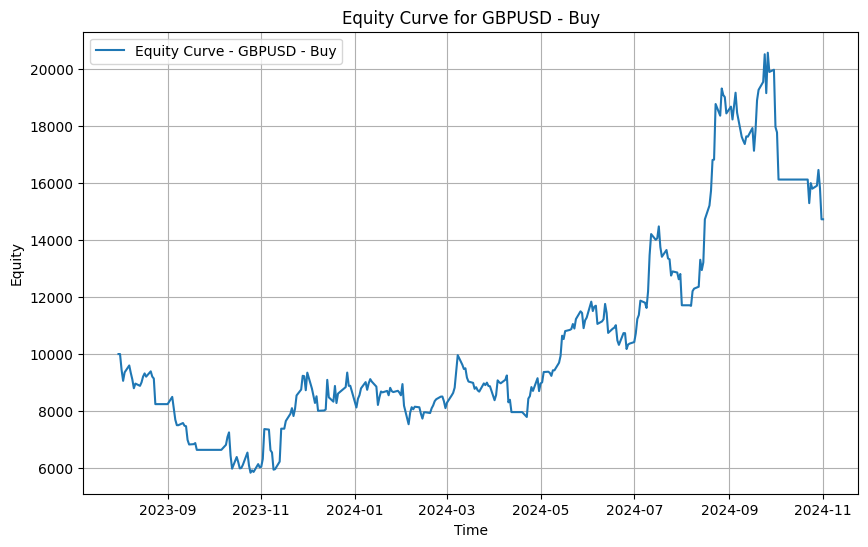

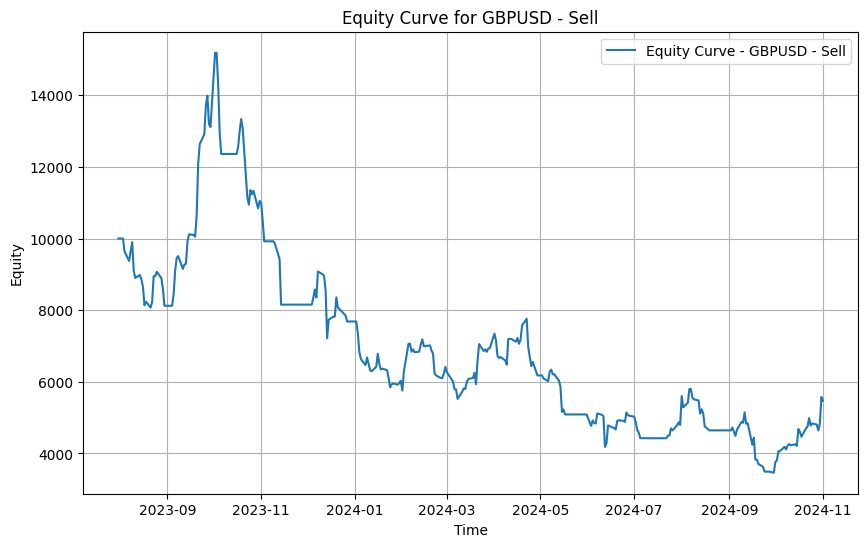

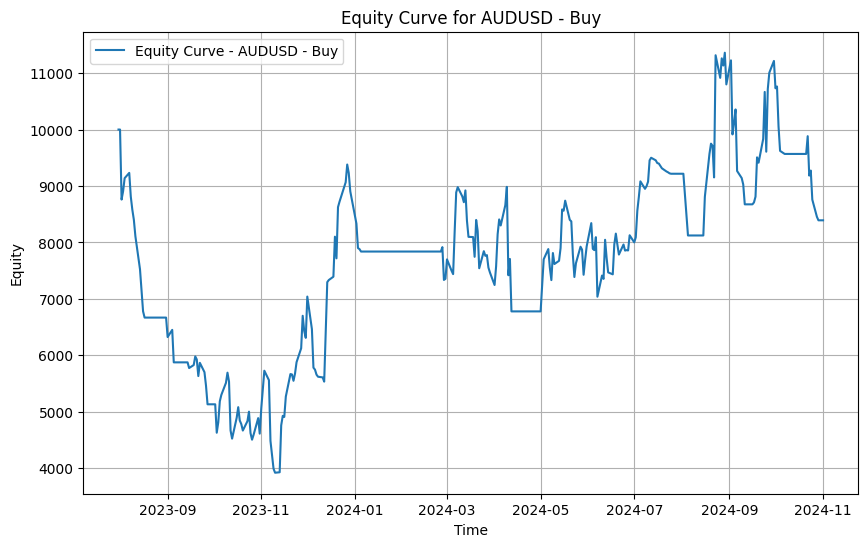

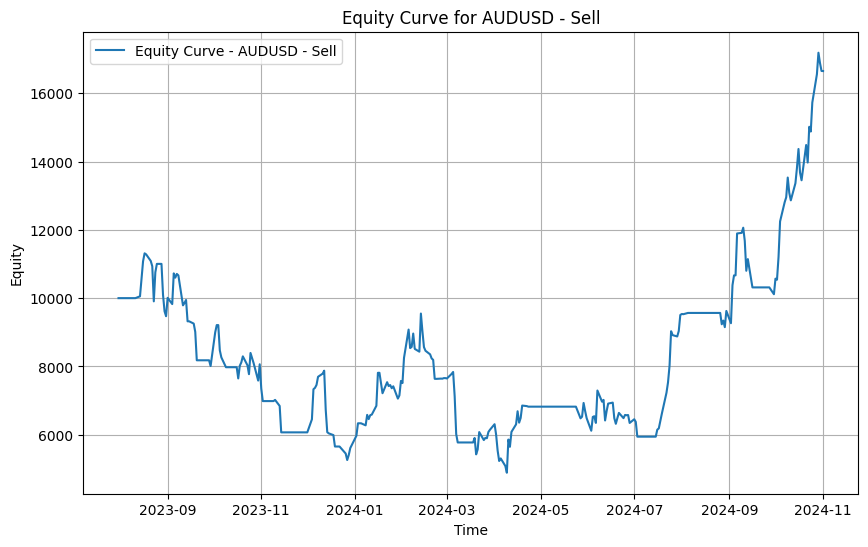

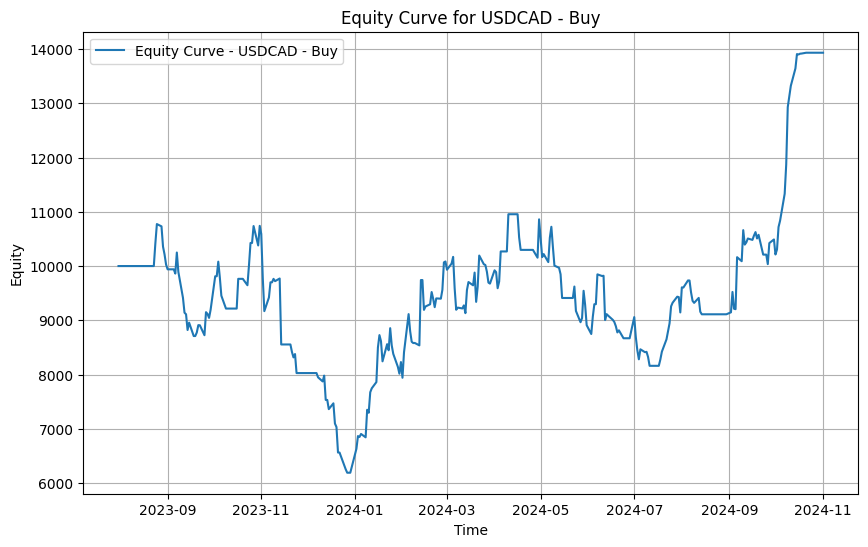

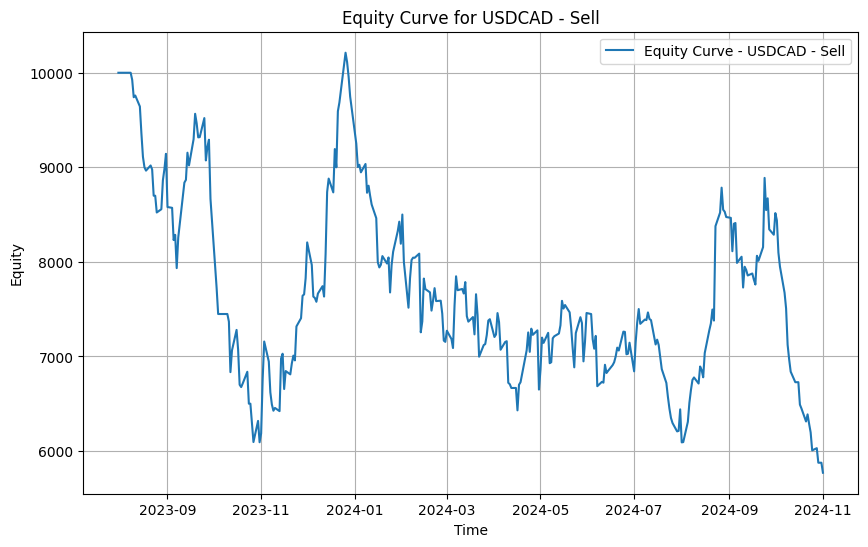


Backtest Results Summary:
     Pair Signal  Margin  Final Equity  Return (%)  Max Drawdown (%)  \
0  EURUSD    Buy     0.1  10772.110367    7.721104        -43.973365   
1  EURUSD   Sell     0.1   7832.972841  -21.670272        -61.278496   
2  GBPUSD    Buy     0.1  14729.602938   47.296029        -41.641059   
3  GBPUSD   Sell     0.1   5469.490398  -45.305096        -77.203742   
4  AUDUSD    Buy     0.1   8391.404014  -16.085960        -60.825888   
5  AUDUSD   Sell     0.1  16654.234168   66.542342        -56.826189   
6  USDCAD    Buy     0.1  13932.486158   39.324862        -42.544078   
7  USDCAD   Sell     0.1   5770.091483  -42.299085        -43.495947   

   Profit Factor  Sharpe Ratio            Equity Curve Image  
0       1.066960      0.097201   EURUSD_Buy_Equity_Curve.png  
1       0.936393      0.000000  EURUSD_Sell_Equity_Curve.png  
2       1.672003      0.375638   GBPUSD_Buy_Equity_Curve.png  
3       1.129277      0.000000  GBPUSD_Sell_Equity_Curve.png  
4       1

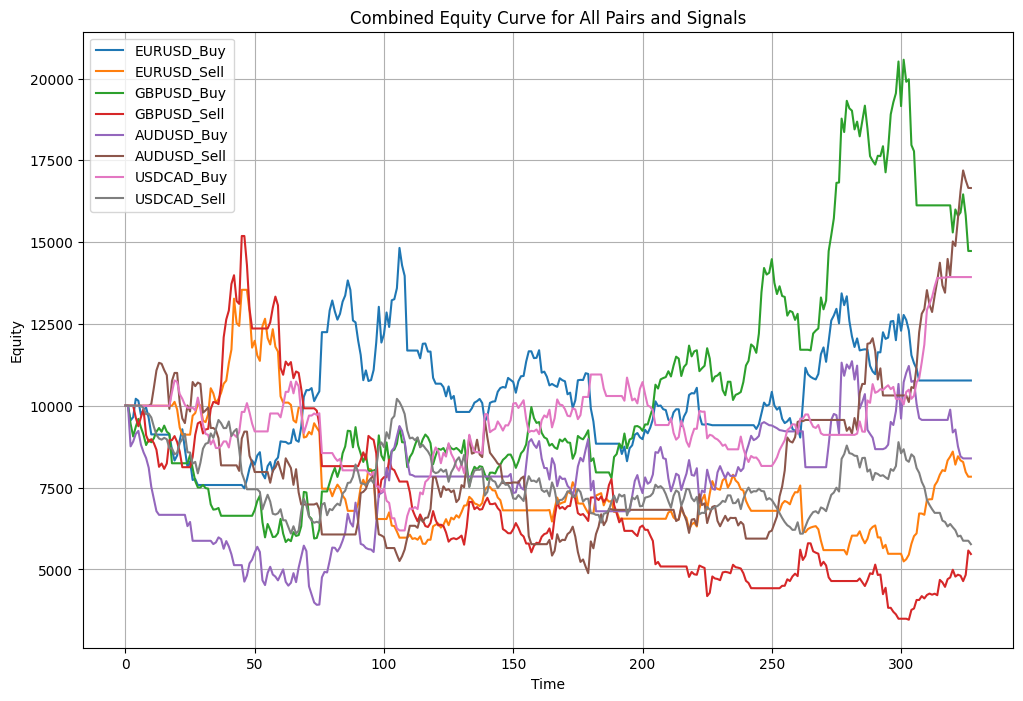

In [ ]:
import pandas as pd
import MetaTrader5 as mt5
from backtesting import Backtest, Strategy
import logging
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import os

# Logging configuration
logging.basicConfig(filename='backtest.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# MetaTrader 5 initialization
def init_mt5_connection(login, password, server):
    if not mt5.initialize(login=login, password=password, server=server):
        logging.error(f"initialize() failed, error code = {mt5.last_error()}")
        sys.exit()
    logging.info("Connected to MetaTrader 5")
    print("Connected to MetaTrader 5")

# Fetch historical OHLC data from MetaTrader 5
def fetch_ohlc_data(symbol, timeframe, start_date, end_date):
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        logging.error(f"Failed to fetch data for {symbol}")
        return None
    ohlc_data = pd.DataFrame(data)
    ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')
    ohlc_data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True)
    return ohlc_data[['time', 'Open', 'High', 'Low', 'Close', 'Volume']]  # Include Volume

# Load and align prediction data
def load_and_align_data(ohlc_data, prediction_file):
    try:
        predictions = pd.read_csv(prediction_file, parse_dates=['time'])
        if 'prediction' not in predictions.columns:
            logging.error(f"'prediction' column not found in {prediction_file}")
            return None
    except Exception as e:
        logging.error(f"Error loading prediction file: {e}")
        return None
    # Merge predictions with OHLC data
    ohlc_data = ohlc_data.merge(predictions[['time', 'prediction']], on='time', how='left')
    ohlc_data['prediction'] = ohlc_data['prediction'].fillna(0)  # Fill missing predictions with 0
    ohlc_data['prediction'] = ohlc_data['prediction'].shift(1)  # Shift predictions to next date
    return ohlc_data

# Backtesting strategy for Buy or Sell
class PredictionStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        risk_part, reward_part = self.risk_reward_ratio
        # Buy signal
        if self.data.prediction[-1] == 1 and self.signal_type == 'Buy':
            sl_price = entry_price - self.mean_candle_size * risk_part
            tp_price = entry_price + self.mean_candle_size * reward_part
            self.buy(sl=sl_price, tp=tp_price)
        # Sell signal
        elif self.data.prediction[-1] == 1 and self.signal_type == 'Sell':
            sl_price = entry_price + self.mean_candle_size * risk_part
            tp_price = entry_price - self.mean_candle_size * reward_part
            self.sell(sl=sl_price, tp=tp_price)

# Function to perform backtesting, save stats/plot, and add to results summary
def run_backtest(ohlc_data, strategy_class, risk_reward_ratio, pair_name, signal_type, mean_candle_size, margin, results_summary, combined_data):
    strategy_class.risk_reward_ratio = risk_reward_ratio
    strategy_class.signal_type = signal_type
    strategy_class.mean_candle_size = mean_candle_size  # Set mean candle size for the strategy
    
    # Run the backtest with specified margin
    bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=10000, commission=.0003, margin=margin)
    stats = bt.run()
    
    # Store equity curve for combined plot
    combined_data[f'{pair_name}_{signal_type}'] = stats['_equity_curve']['Equity'].reset_index(drop=True)

    # Plot and save the equity curve
    equity_curve = stats['_equity_curve']['Equity']
    plt.figure(figsize=(10, 6))
    plt.plot(equity_curve, label=f'Equity Curve - {pair_name} - {signal_type}')
    plt.title(f'Equity Curve for {pair_name} - {signal_type}')
    plt.xlabel('Time')
    plt.ylabel('Equity')
    plt.legend()
    plt.grid(True)
    plot_filename = f"{pair_name}_{signal_type}_Equity_Curve.png"
    plt.savefig(plot_filename)
    plt.show()
    
    # Add the backtest results to the summary
    results_summary.append({
        "Pair": pair_name,
        "Signal": signal_type,
        "Margin": margin,
        "Final Equity": stats['Equity Final [$]'],
        "Return (%)": stats['Return [%]'],
        "Max Drawdown (%)": stats['Max. Drawdown [%]'],
        "Profit Factor": stats['Profit Factor'],
        "Sharpe Ratio": stats['Sharpe Ratio'],
        "Equity Curve Image": plot_filename
    })

# Function to plot combined equity curve for all pairs and signals
def plot_combined_equity_curve(combined_data):
    plt.figure(figsize=(12, 8))
    for label, equity_curve in combined_data.items():
        plt.plot(equity_curve, label=label)
    plt.title("Combined Equity Curve for All Pairs and Signals")
    plt.xlabel("Time")
    plt.ylabel("Equity")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.savefig("Combined_Equity_Curve.png")
    plt.show()

# Main function to fetch OHLC data, align it with prediction data, and run backtest for each buy/sell
def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',
        'EURUSD': {
            'symbol': 'EURUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.009196304524519085,
            'buy_prediction_file': 'pred_EURUSD_Buy.csv',
            'sell_prediction_file': 'pred_EURUSD_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
            'margin': 0.1,
        },
        'GBPUSD': {
            'symbol': 'GBPUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.011,
            'buy_prediction_file': 'pred_GBPUSD_Buy.csv',
            'sell_prediction_file': 'pred_GBPUSD_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
            'margin': 0.1,
        },
        'AUDUSD': {
            'symbol': 'AUDUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.0080,
            'buy_prediction_file': 'pred_AUDUSD_Buy.csv',
            'sell_prediction_file': 'pred_AUDUSD_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
            'margin': 0.1,
        },
        'USDCAD': {
            'symbol': 'USDCAD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.0085,
            'buy_prediction_file': 'pred_USDCAD_Buy.csv',
            'sell_prediction_file': 'pred_USDCAD_Sell.csv',
            'buy_risk_reward_ratio': (1, 1),
            'sell_risk_reward_ratio': (2, 3),
            'margin': 0.1,
        }
    }

    # Initialize MT5 and data range
    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2023, 7, 31, tzinfo=pytz.utc)
    utc_to = datetime(2024, 11, 1, tzinfo=pytz.utc)

    # Results summary list and combined equity data dictionary
    results_summary = []
    combined_data = {}

    for pair_name, pair_config in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue
        logging.info(f"Processing {pair_name}...")
        ohlc_data = fetch_ohlc_data(pair_config['symbol'], pair_config['timeframe'], utc_from, utc_to)
        if ohlc_data is None:
            continue

        # Run backtests for Buy signal
        if pair_config['buy_prediction_file']:
            ohlc_data_with_predictions = load_and_align_data(ohlc_data, pair_config['buy_prediction_file'])
            if ohlc_data_with_predictions is not None:
                run_backtest(ohlc_data_with_predictions, PredictionStrategy, pair_config['buy_risk_reward_ratio'],
                             pair_name, 'Buy', pair_config['mean_candle_size'], pair_config['margin'], results_summary, combined_data)
        
        # Run backtests for Sell signal
        if pair_config.get('sell_prediction_file'):
            ohlc_data_with_predictions = load_and_align_data(ohlc_data, pair_config['sell_prediction_file'])
            if ohlc_data_with_predictions is not None:
                run_backtest(ohlc_data_with_predictions, PredictionStrategy, pair_config['sell_risk_reward_ratio'],
                             pair_name, 'Sell', pair_config['mean_candle_size'], pair_config['margin'], results_summary, combined_data)

    # Display results summary as a DataFrame
    results_df = pd.DataFrame(results_summary)
    print("\nBacktest Results Summary:")
    print(results_df)

    # Plot combined equity curve
    plot_combined_equity_curve(combined_data)

    # Shutdown MT5
    mt5.shutdown()

if __name__ == "__main__":
    main()


Connected to MetaTrader 5


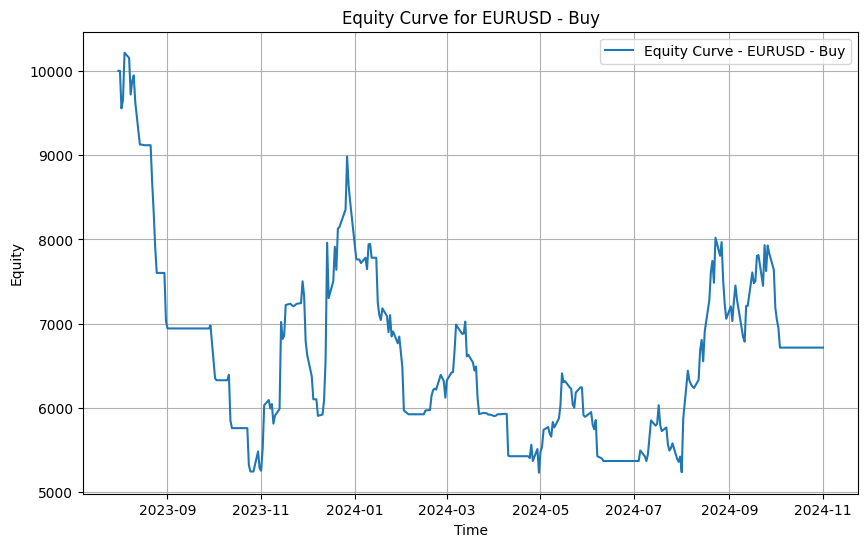

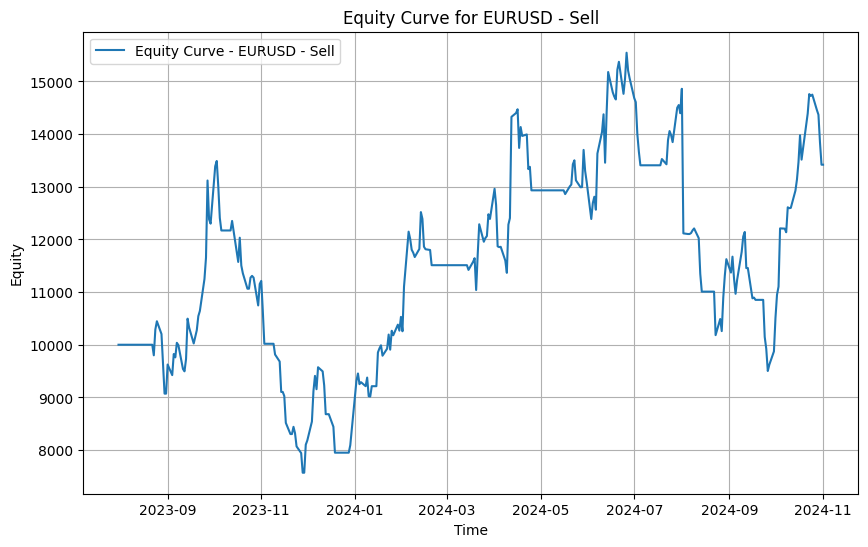

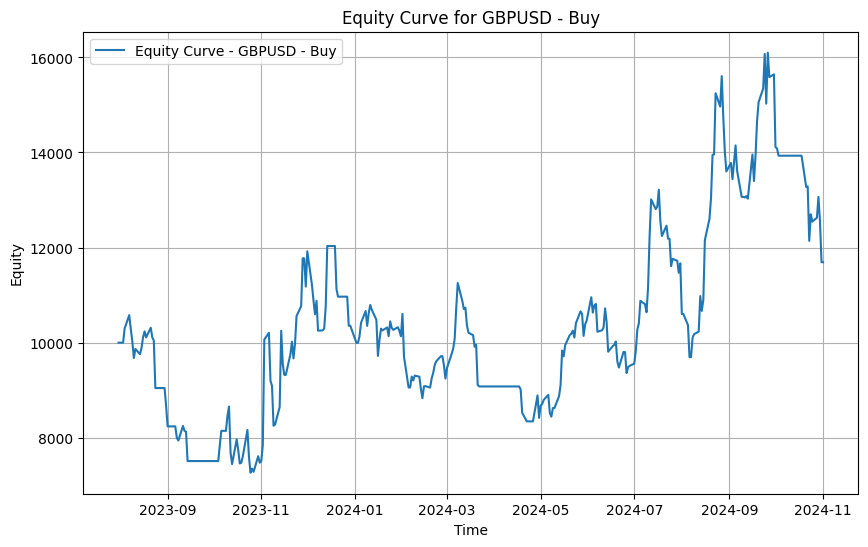

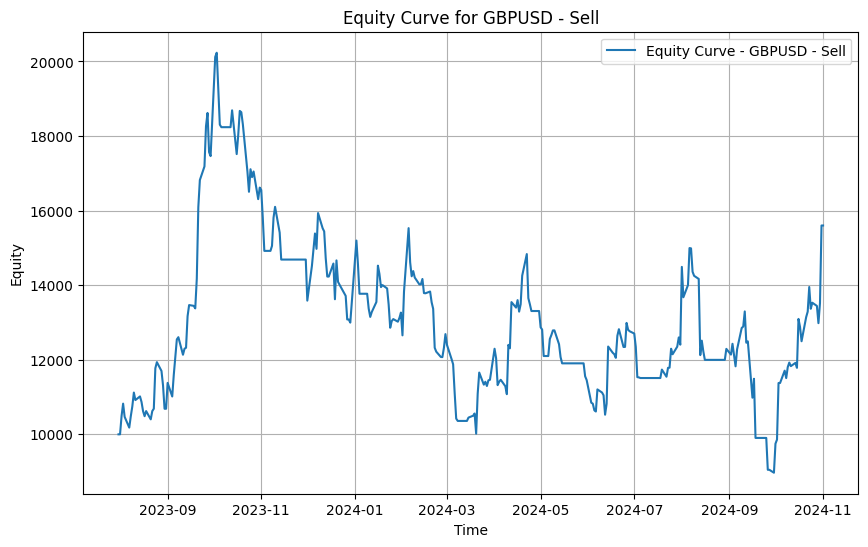

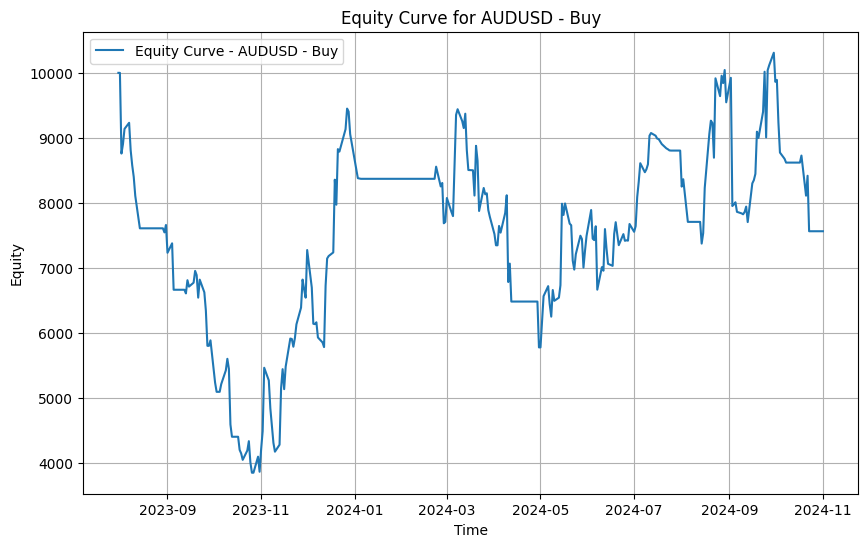

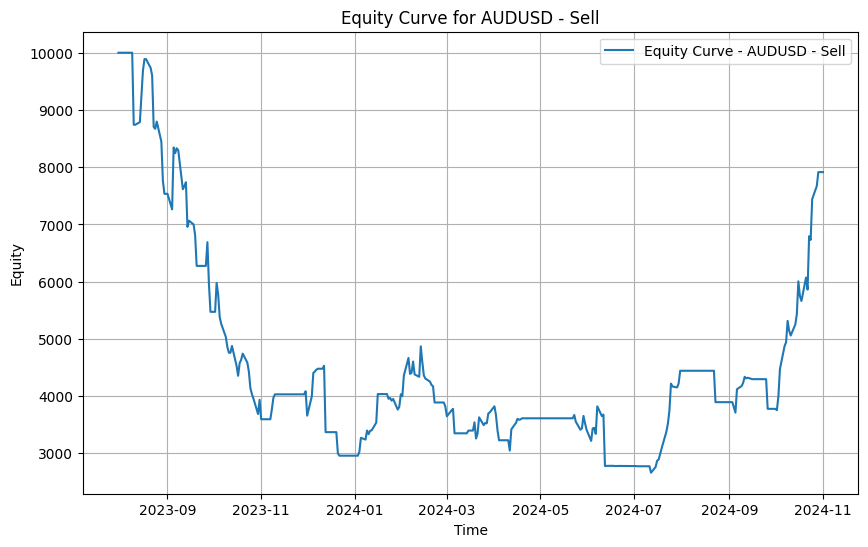

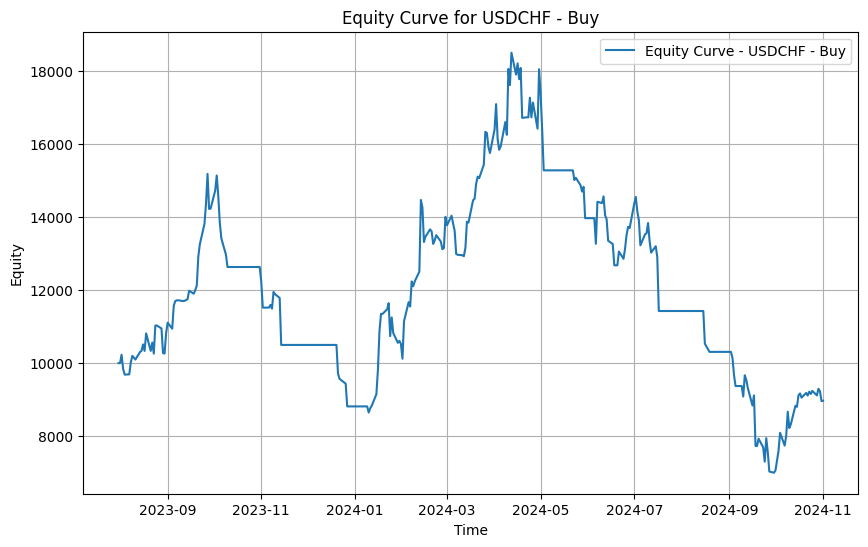

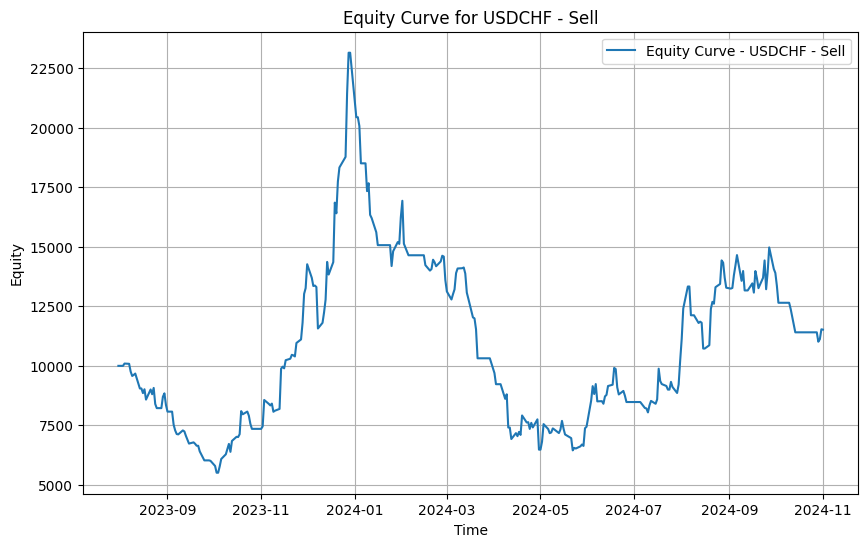

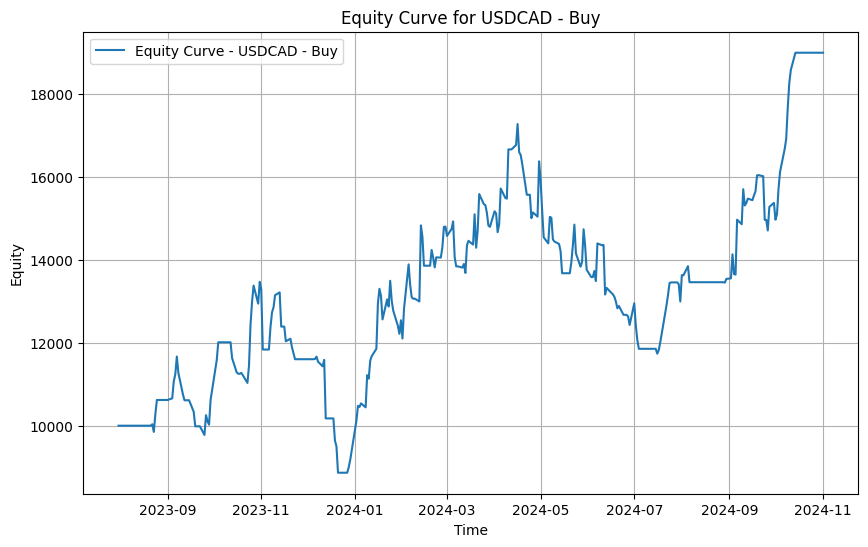

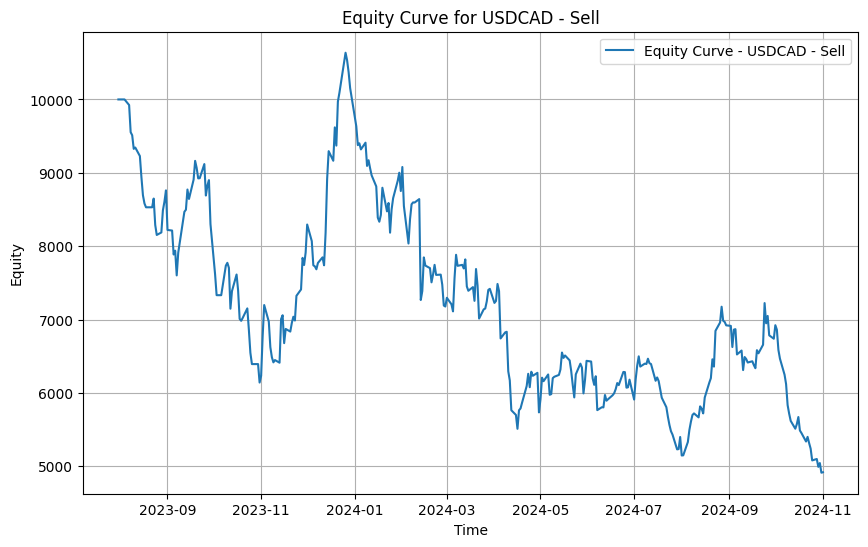


Backtest Results Summary:
     Pair Signal  Margin  Final Equity  Return (%)  Max Drawdown (%)  \
0  EURUSD    Buy     0.1   6716.066508  -32.839335        -48.781153   
1  EURUSD   Sell     0.1  13418.587873   34.185879        -43.883406   
2  GBPUSD    Buy     0.1  11692.684470   16.926845        -31.331097   
3  GBPUSD   Sell     0.1  15599.691058   55.996911        -55.663386   
4  AUDUSD    Buy     0.1   7564.630068  -24.353699        -61.482329   
5  AUDUSD   Sell     0.1   7913.597773  -20.864022        -73.397819   
6  USDCHF    Buy     0.1   8969.704048  -10.302960        -62.186584   
7  USDCHF   Sell     0.1  11519.722500   15.197225        -72.143816   
8  USDCAD    Buy     0.1  18995.840554   89.958406        -34.179799   
9  USDCAD   Sell     0.1   4920.039020  -50.799610        -53.803777   

   Profit Factor  Sharpe Ratio            Equity Curve Image  
0       0.913127      0.000000   EURUSD_Buy_Equity_Curve.png  
1       1.024623      0.349847  EURUSD_Sell_Equity_Cur

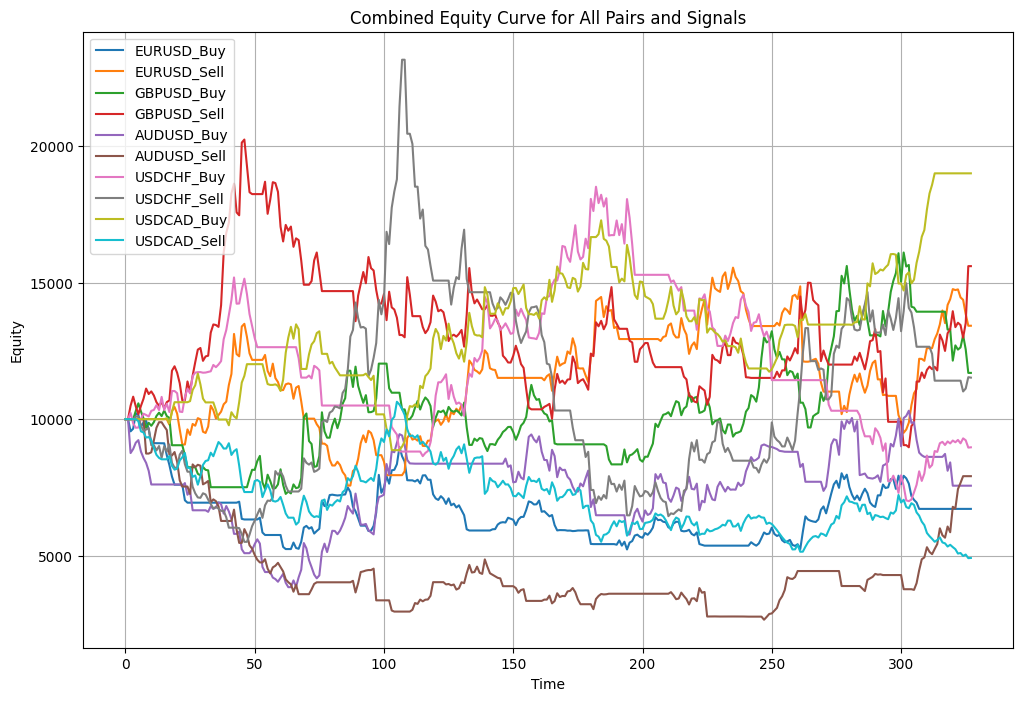

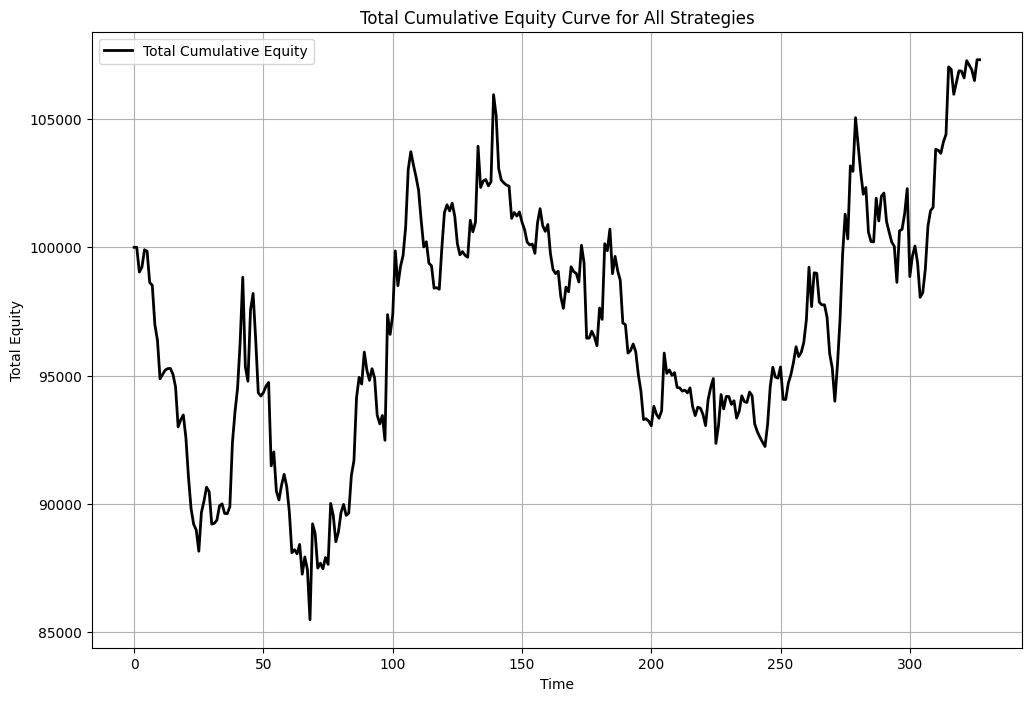

In [7]:
import pandas as pd
import MetaTrader5 as mt5
from backtesting import Backtest, Strategy
import logging
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import os

# Logging configuration
logging.basicConfig(filename='backtest.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# MetaTrader 5 initialization
def init_mt5_connection(login, password, server):
    if not mt5.initialize(login=login, password=password, server=server):
        logging.error(f"initialize() failed, error code = {mt5.last_error()}")
        sys.exit()
    logging.info("Connected to MetaTrader 5")
    print("Connected to MetaTrader 5")

# Fetch historical OHLC data from MetaTrader 5
def fetch_ohlc_data(symbol, timeframe, start_date, end_date):
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        logging.error(f"Failed to fetch data for {symbol}")
        return None
    ohlc_data = pd.DataFrame(data)
    ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')
    ohlc_data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True)
    return ohlc_data[['time', 'Open', 'High', 'Low', 'Close', 'Volume']]  # Include Volume

# Load and align prediction data
def load_and_align_data(ohlc_data, prediction_file):
    try:
        predictions = pd.read_csv(prediction_file, parse_dates=['time'])
        if 'prediction' not in predictions.columns:
            logging.error(f"'prediction' column not found in {prediction_file}")
            return None
    except Exception as e:
        logging.error(f"Error loading prediction file: {e}")
        return None
    # Merge predictions with OHLC data
    ohlc_data = ohlc_data.merge(predictions[['time', 'prediction']], on='time', how='left')
    ohlc_data['prediction'] = ohlc_data['prediction'].fillna(0)  # Fill missing predictions with 0
    ohlc_data['prediction'] = ohlc_data['prediction'].shift(-1)  # Shift predictions to next date
    return ohlc_data

# Backtesting strategy for Buy or Sell
class PredictionStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        risk_part, reward_part = self.risk_reward_ratio
        # Buy signal
        if self.data.prediction[-1] == 1 and self.signal_type == 'Buy':
            sl_price = entry_price - self.mean_candle_size * risk_part
            tp_price = entry_price + self.mean_candle_size * reward_part
            self.buy(sl=sl_price, tp=tp_price)
        # Sell signal
        elif self.data.prediction[-1] == 1 and self.signal_type == 'Sell':
            sl_price = entry_price + self.mean_candle_size * risk_part
            tp_price = entry_price - self.mean_candle_size * reward_part
            self.sell(sl=sl_price, tp=tp_price)

# Function to perform backtesting, save stats/plot, and add to results summary
def run_backtest(ohlc_data, strategy_class, risk_reward_ratio, pair_name, signal_type, mean_candle_size, margin, results_summary, combined_data):
    strategy_class.risk_reward_ratio = risk_reward_ratio
    strategy_class.signal_type = signal_type
    strategy_class.mean_candle_size = mean_candle_size  # Set mean candle size for the strategy
    
    # Run the backtest with specified margin
    bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=10000, commission=.0003, margin=margin)
    stats = bt.run()
    
    # Store equity curve for combined plot
    combined_data[f'{pair_name}_{signal_type}'] = stats['_equity_curve']['Equity'].reset_index(drop=True)

    # Plot and save the equity curve
    equity_curve = stats['_equity_curve']['Equity']
    plt.figure(figsize=(10, 6))
    plt.plot(equity_curve, label=f'Equity Curve - {pair_name} - {signal_type}')
    plt.title(f'Equity Curve for {pair_name} - {signal_type}')
    plt.xlabel('Time')
    plt.ylabel('Equity')
    plt.legend()
    plt.grid(True)
    plot_filename = f"{pair_name}_{signal_type}_Equity_Curve.png"
    plt.savefig(plot_filename)
    plt.show()
    
    # Add the backtest results to the summary
    results_summary.append({
        "Pair": pair_name,
        "Signal": signal_type,
        "Margin": margin,
        "Final Equity": stats['Equity Final [$]'],
        "Return (%)": stats['Return [%]'],
        "Max Drawdown (%)": stats['Max. Drawdown [%]'],
        "Profit Factor": stats['Profit Factor'],
        "Sharpe Ratio": stats['Sharpe Ratio'],
        "Equity Curve Image": plot_filename
    })

# Function to plot combined equity curve for all pairs and signals
def plot_combined_equity_curve(combined_data):
    plt.figure(figsize=(12, 8))
    for label, equity_curve in combined_data.items():
        plt.plot(equity_curve, label=label)
    plt.title("Combined Equity Curve for All Pairs and Signals")
    plt.xlabel("Time")
    plt.ylabel("Equity")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.savefig("Combined_Equity_Curve.png")
    plt.show()

# Function to plot total cumulative equity from all strategies
def plot_total_equity(combined_data):
    # Calculate total equity by summing each equity curve at each point in time
    total_equity_curve = pd.DataFrame(combined_data).sum(axis=1)
    
    # Plot total cumulative equity curve
    plt.figure(figsize=(12, 8))
    plt.plot(total_equity_curve, label="Total Cumulative Equity", color="black", linewidth=2)
    plt.title("Total Cumulative Equity Curve for All Strategies")
    plt.xlabel("Time")
    plt.ylabel("Total Equity")
    plt.legend()
    plt.grid(True)
    plt.savefig("Total_Cumulative_Equity_Curve.png")
    plt.show()

# Main function to fetch OHLC data, align it with prediction data, and run backtest for each buy/sell
def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',
        'EURUSD': {
            'symbol': 'EURUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.009196304524519085,
            'buy_prediction_file': 'pred_EURUSD_Buy.csv',
            'sell_prediction_file': 'pred_EURUSD_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
            'margin': 0.1,
        },
        'GBPUSD': {
            'symbol': 'GBPUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.011,
            'buy_prediction_file': 'pred_GBPUSD_Buy.csv',
            'sell_prediction_file': 'pred_GBPUSD_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
            'margin': 0.1,
        },
        'AUDUSD': {
            'symbol': 'AUDUSD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.0080,
            'buy_prediction_file': 'pred_AUDUSD_Buy.csv',
            'sell_prediction_file': 'pred_AUDUSD_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
            'margin': 0.1,
        },
        'USDCHF': {
            'symbol': 'USDCHF',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.007648387882066531,
            'buy_prediction_file': 'pred_USDCHF_Buy.csv',
            'sell_prediction_file': 'pred_USDCHF_Sell.csv',
            'buy_risk_reward_ratio': (1, 2),
            'sell_risk_reward_ratio': (1, 1),
            'margin': 0.1,
        },
        'USDCAD': {
            'symbol': 'USDCAD',
            'timeframe': mt5.TIMEFRAME_D1,
            'mean_candle_size': 0.0085,
            'buy_prediction_file': 'pred_USDCAD_Buy.csv',
            'sell_prediction_file': 'pred_USDCAD_Sell.csv',
            'buy_risk_reward_ratio': (1, 1),
            'sell_risk_reward_ratio': (2, 3),
            'margin': 0.1,
        }
    }

    # Initialize MT5 and data range
    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2023, 7, 31, tzinfo=pytz.utc)
    utc_to = datetime(2024, 11, 1, tzinfo=pytz.utc)

    # Results summary list and combined equity data dictionary
    results_summary = []
    combined_data = {}

    for pair_name, pair_config in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue
        logging.info(f"Processing {pair_name}...")
        ohlc_data = fetch_ohlc_data(pair_config['symbol'], pair_config['timeframe'], utc_from, utc_to)
        if ohlc_data is None:
            continue

        # Run backtests for Buy signal
        if pair_config['buy_prediction_file']:
            ohlc_data_with_predictions = load_and_align_data(ohlc_data, pair_config['buy_prediction_file'])
            if ohlc_data_with_predictions is not None:
                run_backtest(ohlc_data_with_predictions, PredictionStrategy, pair_config['buy_risk_reward_ratio'],
                             pair_name, 'Buy', pair_config['mean_candle_size'], pair_config['margin'], results_summary, combined_data)
        
        # Run backtests for Sell signal
        if pair_config.get('sell_prediction_file'):
            ohlc_data_with_predictions = load_and_align_data(ohlc_data, pair_config['sell_prediction_file'])
            if ohlc_data_with_predictions is not None:
                run_backtest(ohlc_data_with_predictions, PredictionStrategy, pair_config['sell_risk_reward_ratio'],
                             pair_name, 'Sell', pair_config['mean_candle_size'], pair_config['margin'], results_summary, combined_data)

    # Display results summary as a DataFrame
    results_df = pd.DataFrame(results_summary)
    print("\nBacktest Results Summary:")
    print(results_df)

    # Plot combined equity curve
    plot_combined_equity_curve(combined_data)

    # Plot total cumulative equity
    plot_total_equity(combined_data)

    # Shutdown MT5
    mt5.shutdown()

if __name__ == "__main__":
    main()


Connected to MetaTrader 5


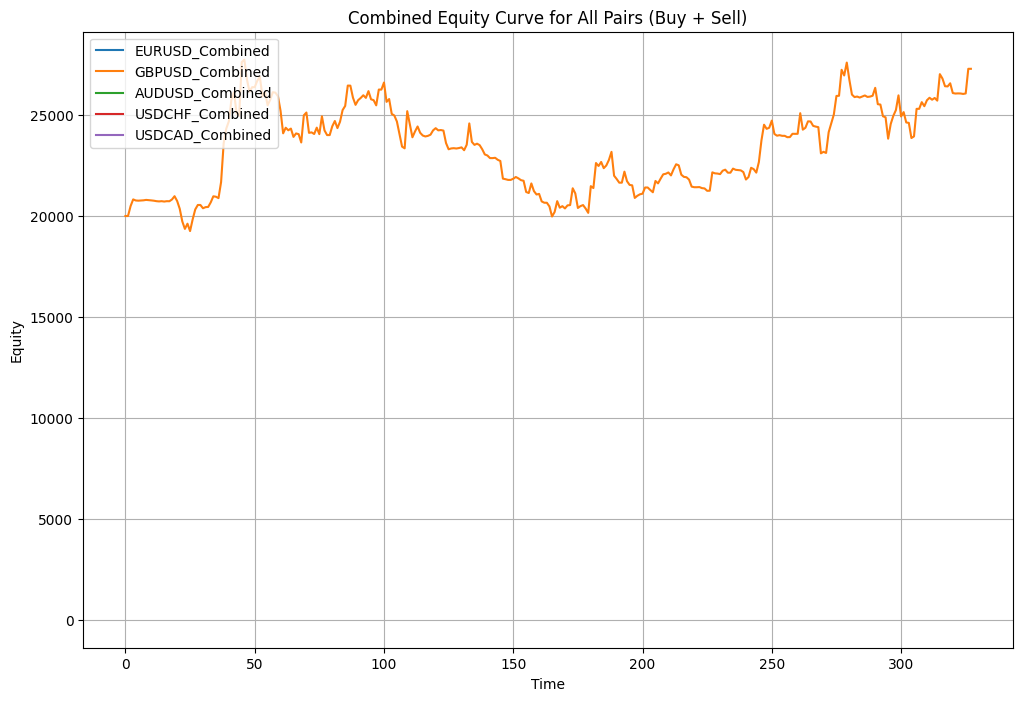

In [4]:
import pandas as pd
import MetaTrader5 as mt5
from backtesting import Backtest, Strategy
import logging
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import os

# Logging configuration
logging.basicConfig(filename='backtest.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# MetaTrader 5 initialization
def init_mt5_connection(login, password, server):
    if not mt5.initialize(login=login, password=password, server=server):
        logging.error(f"initialize() failed, error code = {mt5.last_error()}")
        sys.exit()
    logging.info("Connected to MetaTrader 5")
    print("Connected to MetaTrader 5")

# Fetch historical OHLC data from MetaTrader 5
def fetch_ohlc_data(symbol, timeframe, start_date, end_date):
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        logging.error(f"Failed to fetch data for {symbol}")
        return None
    ohlc_data = pd.DataFrame(data)
    ohlc_data['time'] = pd.to_datetime(ohlc_data['time'], unit='s')
    ohlc_data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True)
    return ohlc_data[['time', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Load and align prediction data
def load_and_align_data(ohlc_data, prediction_file):
    try:
        predictions = pd.read_csv(prediction_file, parse_dates=['time'])
        if 'prediction' not in predictions.columns:
            logging.error(f"'prediction' column not found in {prediction_file}")
            return None
    except Exception as e:
        logging.error(f"Error loading prediction file: {e}")
        return None

    ohlc_data = ohlc_data.merge(predictions[['time', 'prediction']], on='time', how='left')
    ohlc_data['prediction'] = ohlc_data['prediction'].fillna(0)
    ohlc_data['prediction'] = ohlc_data['prediction'].shift(-1)
    return ohlc_data

# Backtesting strategy for Buy or Sell
class PredictionStrategy(Strategy):
    def init(self):
        pass

    def next(self):
        entry_price = self.data.Close[-1]
        risk_part, reward_part = self.risk_reward_ratio

        if self.data.prediction[-1] == 1 and self.signal_type == 'Buy':
            sl_price = entry_price - self.mean_candle_size * risk_part
            tp_price = entry_price + self.mean_candle_size * reward_part
            self.buy(sl=sl_price, tp=tp_price)

        elif self.data.prediction[-1] == 1 and self.signal_type == 'Sell':
            sl_price = entry_price + self.mean_candle_size * risk_part
            tp_price = entry_price - self.mean_candle_size * reward_part
            self.sell(sl=sl_price, tp=tp_price)

# Run backtest
def run_backtest(ohlc_data, strategy_class, risk_reward_ratio, pair_name, signal_type, mean_candle_size, margin, results_summary, combined_data):
    strategy_class.risk_reward_ratio = risk_reward_ratio
    strategy_class.signal_type = signal_type
    strategy_class.mean_candle_size = mean_candle_size

    bt = Backtest(ohlc_data.set_index('time'), strategy_class, cash=10000, commission=.0003, margin=margin)
    stats = bt.run()

    # Store Buy and Sell equity curves separately
    if signal_type == 'Buy':
        combined_data[f'{pair_name}_Buy'] = stats['_equity_curve']['Equity'].reset_index(drop=True)
    elif signal_type == 'Sell':
        combined_data[f'{pair_name}_Sell'] = stats['_equity_curve']['Equity'].reset_index(drop=True)

    results_summary.append({
        "Pair": pair_name,
        "Signal": signal_type,
        "Margin": margin,
        "Final Equity": stats['Equity Final [$]'],
        "Return (%)": stats['Return [%]'],
        "Max Drawdown (%)": stats['Max. Drawdown [%]'],
        "Profit Factor": stats['Profit Factor'],
        "Sharpe Ratio": stats['Sharpe Ratio']
    })

# Combine Buy and Sell equity curves
def combine_buy_sell_equity_curves(combined_data):
    combined_equity_data = {}
    for pair_name in ['EURUSD', 'GBPUSD', 'AUDUSD', 'USDCHF', 'USDCAD']:
        buy_curve = combined_data.get(f'{pair_name}_Buy', pd.Series([0]))
        sell_curve = combined_data.get(f'{pair_name}_Sell', pd.Series([0]))

        max_length = max(len(buy_curve), len(sell_curve))
        buy_curve = buy_curve.reindex(range(max_length), method='ffill').fillna(0)
        sell_curve = sell_curve.reindex(range(max_length), method='ffill').fillna(0)

        combined_curve = buy_curve + sell_curve
        combined_equity_data[f'{pair_name}_Combined'] = combined_curve

    return combined_equity_data

# Plot combined equity curve
def plot_combined_equity_curve(combined_data):
    plt.figure(figsize=(12, 8))
    for label, equity_curve in combined_data.items():
        plt.plot(equity_curve, label=label)
    plt.title("Combined Equity Curve for All Pairs (Buy + Sell)")
    plt.xlabel("Time")
    plt.ylabel("Equity")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.savefig("Combined_Equity_Curve_All_Pairs.png")
    plt.show()

# Main function
def main():
    config = {
        'login': 51988090,
        'password': '1fMdV52$74EOcw',
        'server': 'ICMarketsEU-Demo',
        #'EURUSD': {'symbol': 'EURUSD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.0092, 'buy_prediction_file': 'pred_EURUSD_Buy.csv', 'sell_prediction_file': 'pred_EURUSD_Sell.csv', 'buy_risk_reward_ratio': (1, 2), 'sell_risk_reward_ratio': (1, 1), 'margin': 0.1},
        'GBPUSD': {'symbol': 'GBPUSD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.011, 'buy_prediction_file': 'pred_GBPUSD_Buy.csv', 'sell_prediction_file': 'pred_GBPUSD_Sell.csv', 'buy_risk_reward_ratio': (1, 2), 'sell_risk_reward_ratio': (1, 1), 'margin': 0.1},
        #'AUDUSD': {'symbol': 'AUDUSD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.008, 'buy_prediction_file': 'pred_AUDUSD_Buy.csv', 'sell_prediction_file': 'pred_AUDUSD_Sell.csv', 'buy_risk_reward_ratio': (1, 2), 'sell_risk_reward_ratio': (1, 1), 'margin': 0.1},
        #'USDCHF': {'symbol': 'USDCHF', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.0076, 'buy_prediction_file': 'pred_USDCHF_Buy.csv', 'sell_prediction_file': 'pred_USDCHF_Sell.csv', 'buy_risk_reward_ratio': (1, 2), 'sell_risk_reward_ratio': (1, 1), 'margin': 0.1},
        #'USDCAD': {'symbol': 'USDCAD', 'timeframe': mt5.TIMEFRAME_D1, 'mean_candle_size': 0.0085, 'buy_prediction_file': 'pred_USDCAD_Buy.csv', 'sell_prediction_file': 'pred_USDCAD_Sell.csv', 'buy_risk_reward_ratio': (1, 1), 'sell_risk_reward_ratio': (2, 3), 'margin': 0.1}
    }

    init_mt5_connection(config['login'], config['password'], config['server'])
    utc_from = datetime(2023, 7, 31, tzinfo=pytz.utc)
    utc_to = datetime(2024, 11, 1, tzinfo=pytz.utc)

    results_summary = []
    combined_data = {}

    for pair_name, pair_config in config.items():
        if pair_name in ['login', 'password', 'server']:
            continue

        ohlc_data = fetch_ohlc_data(pair_config['symbol'], pair_config['timeframe'], utc_from, utc_to)
        if ohlc_data is None:
            continue

        # Backtest Buy and Sell signals
        for signal_type in ['Buy', 'Sell']:
            prediction_file = pair_config.get(f'{signal_type.lower()}_prediction_file')
            if prediction_file:
                ohlc_data_with_predictions = load_and_align_data(ohlc_data, prediction_file)
                if ohlc_data_with_predictions is not None:
                    run_backtest(ohlc_data_with_predictions, PredictionStrategy, pair_config[f'{signal_type.lower()}_risk_reward_ratio'], pair_name, signal_type, pair_config['mean_candle_size'], pair_config['margin'], results_summary, combined_data)

    combined_equity_data = combine_buy_sell_equity_curves(combined_data)
    plot_combined_equity_curve(combined_equity_data)

    mt5.shutdown()

if __name__ == "__main__":
    main()
